In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plts
from datetime import datetime


In [2]:
reference_data_new = pd.read_csv("data/raw_aact/combined_neuro_trials_with_interventions_20240313.csv")

In [3]:
reference_data_new[reference_data_new['intervention_name'].str.contains('Lecanemab', case=False, na=False, regex=True)].drop_duplicates()


nct_id Neurological Disease  \
120716  NCT05269394             Dementia   
120719  NCT05269394             Dementia   
120722  NCT05269394             Dementia   
120725  NCT05269394             Dementia   
120728  NCT05269394             Dementia   
...             ...                  ...   
373847  NCT01760005             Dementia   
373855  NCT01760005             Dementia   
373863  NCT01760005             Dementia   
373871  NCT01760005             Dementia   
373894  NCT01760005             Dementia   

                                            Disease Class  \
120716  Diseases of the nervous system|Central Nervous...   
120719  Diseases of the nervous system|Central Nervous...   
120722  Diseases of the nervous system|Central Nervous...   
120725  Diseases of the nervous system|Central Nervous...   
120728  Diseases of the nervous system|Central Nervous...   
...                                                   ...   
373847  Diseases of the nervous system|Central Nervous...   
373855  Diseases of the nervous system|Central Nervous...   
373863  Diseases of the nervous system|Central Nervous...   
373871  Diseases of the nervous system|Central Nervous...   
373894  Diseases of the nervous system|Central Nervous...   

                                              brief_title  \
120716  Dominantly Inherited Alzheimer Network Trial: ...   
120719  Dominantly Inherited Alzheimer Network Trial: ...   
120722  Dominantly Inherited Alzheimer Network Trial: ...   
120725  Dominantly Inherited Alzheimer Network Trial: ...   
120728  Dominantly Inherited Alzheimer Network Trial: ...   
...                                                   ...   
373847  Dominantly Inherited Alzheimer Network Trial: ...   
373855  Dominantly Inherited Alzheimer Network Trial: ...   
373863  Dominantly Inherited Alzheimer Network Trial: ...   
373871  Dominantly Inherited Alzheimer Network Trial: ...   
373894  Dominantly Inherited Alzheimer Network Trial: ...   

                                     study_official_title  \
120716  A Phase II/III Multicenter Randomized, Double-...   
120719  A Phase II/III Multicenter Randomized, Double-...   
120722  A Phase II/III Multicenter Randomized, Double-...   
120725  A Phase II/III Multicenter Randomized, Double-...   
120728  A Phase II/III Multicenter Randomized, Double-...   
...                                                   ...   
373847  A Phase II/III Multicenter Randomized, Double-...   
373855  A Phase II/III Multicenter Randomized, Double-...   
373863  A Phase II/III Multicenter Randomized, Double-...   
373871  A Phase II/III Multicenter Randomized, Double-...   
373894  A Phase II/III Multicenter Randomized, Double-...   

                                brief_summary_description  start_date  \
120716  To assess the safety, tolerability, biomarker,...  2021-12-22   
120719  To assess the safety, tolerability, biomarker,...  2021-12-22   
120722  To assess the safety, tolerability, biomarker,...  2021-12-22   
120725  To assess the safety, tolerability, biomarker,...  2021-12-22   
120728  To assess the safety, tolerability, biomarker,...  2021-12-22   
...                                                   ...         ...   
373847  The purpose of this study is to assess the saf...  2012-12-31   
373855  The purpose of this study is to assess the saf...  2012-12-31   
373863  The purpose of this study is to assess the saf...  2012-12-31   
373871  The purpose of this study is to assess the saf...  2012-12-31   
373894  The purpose of this study is to assess the saf...  2012-12-31   

       completion_date            phase      study_type overall_status  \
120716      2027-10-31  Phase 2/Phase 3  Interventional     Recruiting   
120719      2027-10-31  Phase 2/Phase 3  Interventional     Recruiting   
120722      2027-10-31  Phase 2/Phase 3  Interventional     Recruiting   
120725      2027-10-31  Phase 2/Phase 3  Interventional     Recruiting   
120728      2027-10-31  Phase 2/Phase 

In [4]:
reference_data_new[reference_data_new['intervention_name'].str.contains('Leqembi', case=False, na=False, regex=True)].drop_duplicates()


Empty DataFrame
Columns: [nct_id, Neurological Disease, Disease Class, brief_title, study_official_title, brief_summary_description, start_date, completion_date, phase, study_type, overall_status, country_name, intervention_name, intervention_type]
Index: []

# Load annotated data

In [5]:
data_path = Path("data/annotated_aact/")


In [6]:
df_annotations_all = pd.read_csv(data_path/ "ner_outputs/aggregated_ner_annotations_basic_dict_mapped_19632.csv")
df_annotations_all.shape

(19632, 8)

In [7]:
df_annotations_all.head(2)

Unnamed: 0       nct_id canonical_BioLinkBERT-base_interventions  \
0           0  NCT00000117          intravenous immunoglobulin|ivig   
1           1  NCT00000146                           corticosteroid   

    canonical_aact_interventions aact_intervention_types  \
0                 immunoglobulin                    Drug   
1  prednisone|methylprednisolone                    Drug   

  canonical_BioLinkBERT-base_conditions          canonical_aact_conditions  \
0     multiple sclerosis|optic neuritis                     optic neuritis   
1     multiple sclerosis|optic neuritis  optic neuritis|multiple sclerosis   

                                   Disease Class  
0                         Cranial Nerve Diseases  
1  Demyelinating Diseases|Cranial Nerve Diseases

In [8]:
model_prefix = "combined_union"
entity_types = ["conditions", "interventions"]
if model_prefix == "linkbert":
    mapped_size = [18212, 16917]
elif model_prefix == "aact":
    mapped_size = [19632, 18720]
else:
    mapped_size = [19632, 19632]

In [9]:
# Loop through each entity type, read the corresponding file, and perform the join
for entity_type, mapped_nr in zip(entity_types, mapped_size):
    # Construct the file path
    file_path = data_path / f"snomed_linking_outputs/mapped_to_hierarchy/aact_bert_combined/hierarchical_mapping_to_snomed_{model_prefix}_{entity_type}_aggregated_{mapped_nr}.csv"
    
    # Read the data
    df_entity = pd.read_csv(file_path, index_col=0)
    
    # Perform the left join on nct_id
    df_annotations_all = df_annotations_all.merge(df_entity, on='nct_id', how='left')

if model_prefix == "combined":
    df_annotations_all[f'canonical_combined_{entity_type}'] = df_annotations_all[f'canonical_BioLinkBERT-base_{entity_type}'].combine_first(df_annotations_all[f'canonical_aact_{entity_type}'])


In [10]:
df_annotations_all.shape

(19632, 20)

In [11]:
df_annotations_all.head(10)

Unnamed: 0       nct_id canonical_BioLinkBERT-base_interventions  \
0           0  NCT00000117          intravenous immunoglobulin|ivig   
1           1  NCT00000146                           corticosteroid   
2           2  NCT00000147                           corticosteroid   
3           3  NCT00000151             acetylsalicylic acid|aspirin   
4           4  NCT00000170                                 atropine   
5           5  NCT00000171                                melatonin   
6           6  NCT00000172                              galantamine   
7           7  NCT00000173        donepezil|donepezil hcl|vitamin e   
8           8  NCT00000174          rivastigmine|rivastigmine patch   
9           9  NCT00000175            estrogen|hormone|testosterone   

    canonical_aact_interventions aact_intervention_types  \
0                 immunoglobulin                    Drug   
1  prednisone|methylprednisolone                    Drug   
2  prednisone|methylprednisolone                    Drug   
3   aspirin|acetylsalicylic acid          Procedure|Drug   
4                       atropine             Drug|Device   
5                      melatonin                    Drug   
6                    galantamine                    Drug   
7            vitamin e|donepezil                    Drug   
8                   rivastigmine                    Drug   
9          testosterone|estrogen                    Drug   

               canonical_BioLinkBERT-base_conditions  \
0                  multiple sclerosis|optic neuritis   
1                  multiple sclerosis|optic neuritis   
2                  multiple sclerosis|optic neuritis   
3  diabetes mellitus|diabetic retinopathy|early d...   
4  amblyopia|anisometropia|moderate amblyopia|str...   
5         alzheimer disease|sleep|sleep disturbances   
6                                  alzheimer disease   
7  alzheimer disease|cognitive decline|dementia|m...   
8  alzheimer '|alzheimer disease|dementia|disease...   
9                                                NaN   

               canonical_aact_conditions  \
0                         optic neuritis   
1      optic neuritis|multiple sclerosis   
2      optic neuritis|multiple sclerosis   
3                              blindness   
4                              amblyopia   
5           alzheimer disease|dyssomnias   
6                      alzheimer disease   
7                      alzheimer disease   
8  alzheimer disease|cognition disorders   
9     mood disorders|cognition disorders   

                                       Disease Class  \
0                             Cranial Nerve Diseases   
1      Demyelinating Diseases|Cranial Nerve Diseases   
2      Demyelinating Diseases|Cranial Nerve Diseases   
3                          Neurologic Manifestations   
4                          Neurologic Manifestations   
5    Sleep Wake Disorders|Neurodegenerative Diseases   
6                         Neurodegenerative Diseases   
7                         Neurodegenerative Diseases   
8  Psychiatry and Psychology Category|Neurodegene...   
9                 Psychiatry and Psychology Category   

           linkbert_snomed_term_canonical_conditions  \
0  Multiple sclerosis (disorder)|Optic neuritis (...   
1  Multiple sclerosis (disorder)|Optic neuritis (...   
2  Multiple sclerosis (disorder)|Optic neuritis (...   
3  Diabetes mellitus (disorder)|Retinopathy due t...   
4  Amblyopia (disorder)|Anisometropia (disorder)|...   
5  Alzheimer's disease (disorder)|Asleep (finding...   
6                     Alzheimer's disease (disorder)   
7  Alzheimer's disease (disorder)|Impaired cognit...   
8  Alzheimer's disease (disorder)|Dementia (disor...   
9                                                NaN   

     linkbert_top_concept_canonical_first_conditions  \
0  Multiple sclerosis (disorder)|Optic neuritis (...   
1  Multiple sclerosis (disorder)|Optic neuritis (...   
2  Multiple sclerosis (disorder)|Optic neuritis (...   


In [12]:
df_annotations_all[df_annotations_all['nct_id']=='NCT00000218']

Unnamed: 0       nct_id canonical_BioLinkBERT-base_interventions  \
33          33  NCT00000218                carbamazepine|desipramine   

   canonical_aact_interventions aact_intervention_types  \
33                carbamazepine                    Drug   

   canonical_BioLinkBERT-base_conditions  \
33                       cocaine craving   

                            canonical_aact_conditions      Disease Class  \
33  substance-related disorders|cocaine-related di...  Diseases Category   

   linkbert_snomed_term_canonical_conditions  \
33                           cocaine craving   

   linkbert_top_concept_canonical_first_conditions  \
33                                 cocaine craving   

                aact_snomed_term_canonical_conditions  \
33  Substance-related disorders|Disorder caused by...   

          aact_top_concept_canonical_first_conditions  \
33  Substance-related disorders|Disorder caused by...   

      combined_union_snomed_term_canonical_conditions  \
33  Disorder caused by cocaine (disorder)|Substanc...   

   combined_union_top_concept_canonical_first_conditions  \
33  Disorder caused by cocaine (disorder)|Substanc...      

         linkbert_snomed_term_canonical_interventions  \
33  Carbamazepine (substance)|Desipramine (substance)   

   linkbert_top_concept_canonical_first_interventions  \
33  Carbamazepine (substance)|Antidepressant (subs...   

   aact_snomed_term_canonical_interventions  \
33                Carbamazepine (substance)   

   aact_top_concept_canonical_first_interventions  \
33                      Carbamazepine (substance)   

   combined_union_snomed_term_canonical_interventions  \
33  Carbamazepine (substance)|Desipramine (substance)   

   combined_union_top_concept_canonical_first_interventions  
33                          Carbamazepine (substance)

### Prepare for analysis
NOTE: The reference that in this version contains only the neuro trials, which contained an intervention annotation from BioLinkBERT (DRUG) or AACT

#### decide which columns to plot

In [13]:
evaluate_snomed_link = True
hierarchical_mapping_conditions = True
hierarchical_mapping_interventions = False

if  model_prefix == "linkbert":
    target_ner_column_prefix = 'canonical_BioLinkBERT-base'
elif model_prefix == "aact":
    target_ner_column_prefix = 'canonical_aact'
else:
    target_ner_column_prefix = 'canonical_combined'

if evaluate_snomed_link:
    if hierarchical_mapping_conditions and hierarchical_mapping_interventions:
        target_interventions_column = f'{model_prefix}_top_concept_canonical_first_interventions'
        target_conditions_column = f'{model_prefix}_top_concept_canonical_first_conditions'
        annotations_type = f'{model_prefix}_sapbert_hierarchical'
    elif hierarchical_mapping_conditions and (not hierarchical_mapping_interventions):
        target_interventions_column = f'{model_prefix}_snomed_term_canonical_interventions'
        target_conditions_column = f'{model_prefix}_top_concept_canonical_first_conditions'
        annotations_type = f'{model_prefix}_sapbert_cond_hier'
    elif hierarchical_mapping_interventions and (not hierarchical_mapping_conditions):
        target_interventions_column = f'{model_prefix}_top_concept_canonical_first_interventions'
        target_conditions_column = f'{model_prefix}_snomed_term_canonical_conditions'
        annotations_type = f'{model_prefix}_sapbert_interv_hier'
    else:
        target_interventions_column = f'{model_prefix}_snomed_term_canonical_interventions'
        target_conditions_column = f'{model_prefix}_snomed_term_canonical_conditions'
        annotations_type = f'{model_prefix}_sapbert'
else:
    target_interventions_column = f'{target_ner_column_prefix}_interventions'
    target_conditions_column = f'{target_ner_column_prefix}_conditions'
    annotations_type = model_prefix


In [14]:
target_interventions_column, target_conditions_column

('combined_union_snomed_term_canonical_interventions',
 'combined_union_top_concept_canonical_first_conditions')

In [15]:
annotations_type

'combined_union_sapbert_cond_hier'

#### select columns to plot and merge with metadata

In [16]:
df_normalized_annotations = df_annotations_all[['nct_id', target_interventions_column, target_conditions_column]]
reference_data_with_target_annotations = df_normalized_annotations.merge(reference_data_new, on='nct_id', how='left')
reference_data_with_target_annotations.head(2)

nct_id combined_union_snomed_term_canonical_interventions  \
0  NCT00000117  Administration of immunoglobulin by intravenou...   
1  NCT00000117  Administration of immunoglobulin by intravenou...   

  combined_union_top_concept_canonical_first_conditions Neurological Disease  \
0  Multiple sclerosis (disorder)|Optic neuritis (...          Optic Neuritis   
1  Multiple sclerosis (disorder)|Optic neuritis (...          Optic Neuritis   

            Disease Class                                        brief_title  \
0  Cranial Nerve Diseases  Intravenous Immunoglobulin Therapy in Optic Ne...   
1  Cranial Nerve Diseases  Intravenous Immunoglobulin Therapy in Optic Ne...   

  study_official_title                          brief_summary_description  \
0                  NaN  To determine whether high-dose intravenous imm...   
1                  NaN  To determine whether high-dose intravenous imm...   

   start_date completion_date    phase      study_type overall_status  \
0  1995-08-31      1997-12-31  Phase 3  Interventional      Completed   
1  1995-08-31      1997-12-31  Phase 3  Interventional      Completed   

    country_name intervention_name intervention_type  
0  United States    Immunoglobulin              Drug  
1  United States    Immunoglobulin              Drug

In [17]:
reference_data_with_target_annotations_to_save = reference_data_with_target_annotations[['nct_id','brief_title', 'Neurological Disease', 'Disease Class', 'brief_summary_description']]

In [18]:
reference_data_with_target_annotations_to_save.head()

nct_id                                        brief_title  \
0  NCT00000117  Intravenous Immunoglobulin Therapy in Optic Ne...   
1  NCT00000117  Intravenous Immunoglobulin Therapy in Optic Ne...   
2  NCT00000117  Intravenous Immunoglobulin Therapy in Optic Ne...   
3  NCT00000146              Optic Neuritis Treatment Trial (ONTT)   
4  NCT00000146              Optic Neuritis Treatment Trial (ONTT)   

  Neurological Disease           Disease Class  \
0       Optic Neuritis  Cranial Nerve Diseases   
1       Optic Neuritis  Cranial Nerve Diseases   
2       Optic Neuritis  Cranial Nerve Diseases   
3   Multiple Sclerosis  Demyelinating Diseases   
4   Multiple Sclerosis  Demyelinating Diseases   

                           brief_summary_description  
0  To determine whether high-dose intravenous imm...  
1  To determine whether high-dose intravenous imm...  
2  To determine whether high-dose intravenous imm...  
3  To assess the beneficial and adverse effects o...  
4  To assess the beneficial and adverse effects o...

In [19]:
len(set(reference_data_with_target_annotations['nct_id'])), reference_data_with_target_annotations.shape

(19632, (262638, 16))

In [20]:
reference_data_with_target_annotations.head(2)

nct_id combined_union_snomed_term_canonical_interventions  \
0  NCT00000117  Administration of immunoglobulin by intravenou...   
1  NCT00000117  Administration of immunoglobulin by intravenou...   

  combined_union_top_concept_canonical_first_conditions Neurological Disease  \
0  Multiple sclerosis (disorder)|Optic neuritis (...          Optic Neuritis   
1  Multiple sclerosis (disorder)|Optic neuritis (...          Optic Neuritis   

            Disease Class                                        brief_title  \
0  Cranial Nerve Diseases  Intravenous Immunoglobulin Therapy in Optic Ne...   
1  Cranial Nerve Diseases  Intravenous Immunoglobulin Therapy in Optic Ne...   

  study_official_title                          brief_summary_description  \
0                  NaN  To determine whether high-dose intravenous imm...   
1                  NaN  To determine whether high-dose intravenous imm...   

   start_date completion_date    phase      study_type overall_status  \
0  1995-08-31      1997-12-31  Phase 3  Interventional      Completed   
1  1995-08-31      1997-12-31  Phase 3  Interventional      Completed   

    country_name intervention_name intervention_type  
0  United States    Immunoglobulin              Drug  
1  United States    Immunoglobulin              Drug

#### explode to have single entity per row

In [21]:
drug_col_name = 'Drug Intervention'
condition_col_name = 'Neurological Condition'

In [22]:
# replace the raw aact column with normalized columns
reference_data_with_target_annotations = reference_data_with_target_annotations.drop(columns=['Neurological Disease', 'intervention_name'])

reference_data_with_target_annotations[target_interventions_column] = reference_data_with_target_annotations[target_interventions_column].str.split('|')
reference_data_with_target_annotations[target_conditions_column] = reference_data_with_target_annotations[target_conditions_column].str.split('|')

# Exploding both columns to create new rows for each value
df_exploded_target_annotations = reference_data_with_target_annotations.explode(target_interventions_column)
df_exploded_target_annotations = df_exploded_target_annotations.explode(target_conditions_column)

# rename the target model columns to a standard column name
df_exploded_target_annotations.rename(columns={target_interventions_column: drug_col_name}, inplace=True)
df_exploded_target_annotations.rename(columns={target_conditions_column: condition_col_name}, inplace=True)

reference_data = df_exploded_target_annotations.copy()
# Convert 'start_date' and 'completion_date' to datetime
reference_data['start_date'] = pd.to_datetime(reference_data['start_date'])
reference_data['completion_date'] = pd.to_datetime(reference_data['completion_date'])

# Extract the year from 'start_date' and 'completion_date'
reference_data['start_year'] = reference_data['start_date'].dt.year
reference_data['completion_year'] = reference_data['completion_date'].dt.year

reference_data = reference_data[reference_data['start_year']<2024]
reference_data = reference_data[reference_data['start_year']>=2000]


In [23]:
len(set(reference_data['nct_id']))

18609

In [24]:
# Function to format long intervention names with new line after every 4 words
def format_long_name(name, max_words=4):
    if isinstance(name, float):
        return ''  # Handle NaN values
    words = name.split()
    if len(words) > max_words:
        return '\n'.join([' '.join(words[i:i+max_words]) for i in range(0, len(words), max_words)])
    return name

# Apply the formatting function to the dataframe
reference_data[drug_col_name] = reference_data[drug_col_name].apply(format_long_name)
reference_data[condition_col_name] = reference_data[condition_col_name].apply(format_long_name)


In [25]:
reference_data_with_entity_tags = reference_data.copy()

In [26]:
len(set(reference_data_with_entity_tags['nct_id']))

18609

#### remove snomed (type)

In [27]:
# Function to remove (substance) and (disorder) suffixes
def remove_suffixes(text, concept_type_subset):
    if isinstance(text, str):
        for suffix in concept_type_subset:
            text = text.replace(f'({suffix})', '').strip()
    return text

concept_type_subset = [
    "disorder",  
    "substance",
    "finding",
    "procedure",
    "medicinal product"
]
# Apply the function to the relevant columns
reference_data[drug_col_name] = reference_data[drug_col_name].apply(lambda x: remove_suffixes(x, concept_type_subset))
reference_data[condition_col_name] = reference_data[condition_col_name].apply(lambda x: remove_suffixes(x, concept_type_subset))


In [28]:
reference_data.shape

(2829638, 16)

In [29]:
reference_data.head(2)

nct_id Drug Intervention      Neurological Condition  \
382  NCT00000307        Naltrexone  Disorder caused by alcohol   
382  NCT00000307        Naltrexone  Disorder caused by cocaine   

         Disease Class                                        brief_title  \
382  Diseases Category  Naltrexone as Adjunct in Alcoholic Cocaine Dep...   
382  Diseases Category  Naltrexone as Adjunct in Alcoholic Cocaine Dep...   

                                  study_official_title  \
382  Naltrexone as an Adjunct in Alcoholic Cocaine ...   
382  Naltrexone as an Adjunct in Alcoholic Cocaine ...   

                             brief_summary_description start_date  \
382  The purpose of this study is to evaluate naltr... 2003-04-30   
382  The purpose of this study is to evaluate naltr... 2003-04-30   

    completion_date    phase      study_type overall_status   country_name  \
382      2007-04-30  Phase 2  Interventional      Completed  United States   
382      2007-04-30  Phase 2  Interventional      Completed  United States   

    intervention_type  start_year  completion_year  
382              Drug      2003.0           2007.0  
382              Drug      2003.0           2007.0

In [30]:
len(set(df_normalized_annotations['nct_id'])), df_normalized_annotations.shape

(19632, (19632, 3))

In [31]:
len(set(reference_data['nct_id']))

18609

# Diseases

In [32]:
viz_path_diseases = Path("viz/conditions/")

In [33]:
reference_data.head(5)

nct_id Drug Intervention       Neurological Condition  \
382  NCT00000307        Naltrexone   Disorder caused by alcohol   
382  NCT00000307        Naltrexone   Disorder caused by cocaine   
382  NCT00000307        Naltrexone  alcoholic cocaine dependent   
383  NCT00000307        Naltrexone   Disorder caused by alcohol   
383  NCT00000307        Naltrexone   Disorder caused by cocaine   

         Disease Class                                        brief_title  \
382  Diseases Category  Naltrexone as Adjunct in Alcoholic Cocaine Dep...   
382  Diseases Category  Naltrexone as Adjunct in Alcoholic Cocaine Dep...   
382  Diseases Category  Naltrexone as Adjunct in Alcoholic Cocaine Dep...   
383  Diseases Category  Naltrexone as Adjunct in Alcoholic Cocaine Dep...   
383  Diseases Category  Naltrexone as Adjunct in Alcoholic Cocaine Dep...   

                                  study_official_title  \
382  Naltrexone as an Adjunct in Alcoholic Cocaine ...   
382  Naltrexone as an Adjunct in Alcoholic Cocaine ...   
382  Naltrexone as an Adjunct in Alcoholic Cocaine ...   
383  Naltrexone as an Adjunct in Alcoholic Cocaine ...   
383  Naltrexone as an Adjunct in Alcoholic Cocaine ...   

                             brief_summary_description start_date  \
382  The purpose of this study is to evaluate naltr... 2003-04-30   
382  The purpose of this study is to evaluate naltr... 2003-04-30   
382  The purpose of this study is to evaluate naltr... 2003-04-30   
383  The purpose of this study is to evaluate naltr... 2003-04-30   
383  The purpose of this study is to evaluate naltr... 2003-04-30   

    completion_date    phase      study_type overall_status   country_name  \
382      2007-04-30  Phase 2  Interventional      Completed  United States   
382      2007-04-30  Phase 2  Interventional      Completed  United States   
382      2007-04-30  Phase 2  Interventional      Completed  United States   
383      2007-04-30  Phase 2  Interventional      Completed  United States   
383      2007-04-30  Phase 2  Interventional      Completed  United States   

    intervention_type  start_year  completion_year  
382              Drug      2003.0           2007.0  
382              Drug      2003.0           2007.0  
382              Drug      2003.0           2007.0  
383              Drug      2003.0           2007.0  
383              Drug      2003.0           2007.0

In [34]:
reference_data.columns

Index(['nct_id', 'Drug Intervention', 'Neurological Condition',
       'Disease Class', 'brief_title', 'study_official_title',
       'brief_summary_description', 'start_date', 'completion_date', 'phase',
       'study_type', 'overall_status', 'country_name', 'intervention_type',
       'start_year', 'completion_year'],
      dtype='object')

In [35]:
aact_diseases = reference_data[['nct_id', condition_col_name, 'Disease Class', 'phase', 'overall_status','start_year','completion_year']]

In [124]:
def plot_entity_frequency(data, entity_column, entity_type, annotations_type, viz_path, top_n=20):
    """
    Generates a horizontal bar chart for the frequency of entities (e.g., diseases, interventions) 
    and saves it to a specified path.

    Parameters:
    data (pd.DataFrame): The input dataframe containing 'nct_id' and the specified entity column.
    entity_column (str): The column name in the dataframe representing the entities (e.g., diseases, interventions).
    annotations_type (str): A string to specify the type of annotations for the title and filename.
    viz_path (Path or str): The path where the plot image will be saved.
    top_n (int): The number of top items to display in the chart. Default is 20.
    """

    # Keeping only unique nct_id, entity pairs
    unique_pairs = data[['nct_id', entity_column]].drop_duplicates()

    # Counting the number of nct_ids per entity type
    entity_counts = unique_pairs[entity_column].value_counts()
    entity_counts = entity_counts.sort_values(ascending=True).tail(top_n)

    # Create a horizontal bar chart for the top N data types
    plt.figure(figsize=(10, 8))
    bars = plt.barh(entity_counts.index, entity_counts, color='lightgrey', zorder=2, height=0.7)  #)

    # Add labels to each bar
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width}', va='center', fontsize=12)

    plt.tick_params(axis='y', labelsize=14)
    plt.tick_params(axis='x', labelsize=15)
    plt.grid(axis='x', linestyle='--', alpha=0.6, zorder=1)
    plt.xlabel('Number of unique trials', fontsize=15)
    plt.title(f'Top {top_n} {entity_column}', fontsize=15)
    plt.xlim(0, max(entity_counts) + max(entity_counts)/10)  # Adjusted to max count for relevancy
    plt.tight_layout()

    # Save the plot to the specified path
    plot_filename = viz_path / f'{entity_type}_frequency_{annotations_type}.pdf'
    plt.savefig(plot_filename)

    # Display the chart
    plt.show()


In [125]:
condition_col_name

'Neurological Condition'

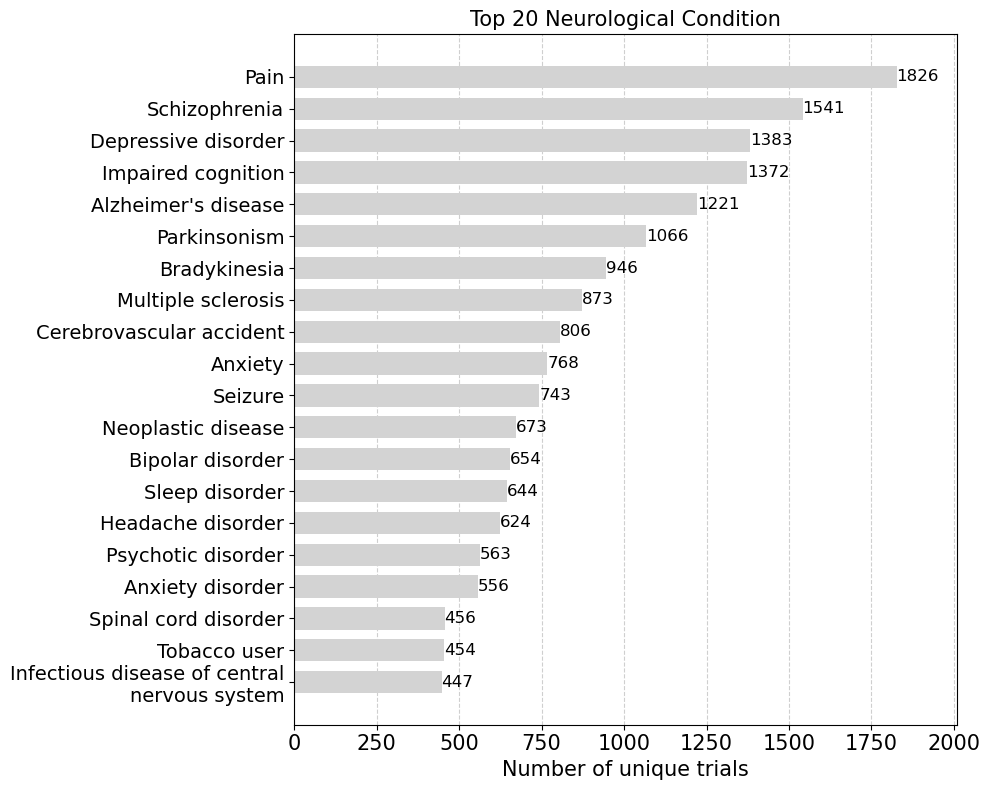

In [126]:
plot_entity_frequency(aact_diseases, condition_col_name, 'disease', annotations_type, viz_path_diseases, top_n=20)


## Disease/ All and Completed Trials

In [39]:
aact_diseases[['nct_id', condition_col_name]].drop_duplicates()

nct_id       Neurological Condition
382     NCT00000307   Disorder caused by alcohol
382     NCT00000307   Disorder caused by cocaine
382     NCT00000307  alcoholic cocaine dependent
438     NCT00000333                      Cocaine
438     NCT00000333   Disorder caused by cocaine
...             ...                          ...
262587  NCT06292351           Impaired cognition
262602  NCT06293586                   Strabismus
262602  NCT06293586           Surgical procedure
262602  NCT06293586                           oc
262602  NCT06293586          oculocardiac reflex

[56239 rows x 2 columns]

In [40]:
# Step 1: Count total trials per disease
total_disease_counts = aact_diseases[['nct_id', condition_col_name]].drop_duplicates()[condition_col_name].value_counts()

# Filter 'Completed' status and count completed trials per disease
completed_trials = aact_diseases[aact_diseases['overall_status'] == 'Completed']
completed_disease_counts = completed_trials[['nct_id', condition_col_name]].drop_duplicates()[condition_col_name].value_counts()

# Calculate proportions of completed trials
completed_proportions = (completed_disease_counts / total_disease_counts).fillna(0) * 100  # Proportion in percentage

# Sorting to get top 20 diseases by total count
sorted_diseases = total_disease_counts.sort_values(ascending=True).tail(20)
sorted_completed_proportions = completed_proportions.reindex(index=sorted_diseases.index)
sorted_completed_proportions

Neurological Condition
Infectious disease of central\nnervous system    78.076063
Tobacco user                                     76.651982
Spinal cord disorder                             54.824561
Anxiety disorder                                 58.093525
Psychotic disorder                               71.936057
Headache disorder                                66.185897
Sleep disorder                                   63.043478
Bipolar disorder                                 69.877676
Neoplastic disease                               49.182764
Seizure                                          66.487214
Anxiety                                          55.989583
Cerebrovascular accident                         51.488834
Multiple sclerosis                               58.419244
Bradykinesia                                     60.359408
Parkinsonism                                     63.320826
Alzheimer's disease                              62.162162
Impaired cognition               

In [41]:
total_disease_counts[:50]

Neurological Condition
Pain                                             1826
Schizophrenia                                    1541
Depressive disorder                              1383
Impaired cognition                               1372
Alzheimer's disease                              1221
Parkinsonism                                     1066
Bradykinesia                                      946
Multiple sclerosis                                873
Cerebrovascular accident                          806
Anxiety                                           768
Seizure                                           743
Neoplastic disease                                673
Bipolar disorder                                  654
Sleep disorder                                    644
Headache disorder                                 624
Psychotic disorder                                563
Anxiety disorder                                  556
Spinal cord disorder                              456
Tobac

In [42]:
top_50 = total_disease_counts.index[:50]

In [43]:
top_50

Index(['Pain', 'Schizophrenia', 'Depressive disorder', 'Impaired cognition',
       'Alzheimer's disease', 'Parkinsonism', 'Bradykinesia',
       'Multiple sclerosis', 'Cerebrovascular accident', 'Anxiety', 'Seizure',
       'Neoplastic disease', 'Bipolar disorder', 'Sleep disorder',
       'Headache disorder', 'Psychotic disorder', 'Anxiety disorder',
       'Spinal cord disorder', 'Tobacco user',
       'Infectious disease of central\nnervous system', 'Infectious disease',
       'Surgical procedure', 'Neuralgia', 'Congenital malformation',
       'Motor neuron disease', 'Neoplasm of nervous system',
       'Developmental mental disorder', 'Schizoaffective disorder',
       'Motor dysfunction', 'Traumatic brain injury', 'Erectile dysfunction',
       'No sensitivity to pain', 'Pervasive developmental disorder',
       'Hereditary metabolic disease', 'Substance-related disorders',
       'Sleep apnea', 'Symptoms of depression', 'Sarcopenia',
       'Sexual disorder', 'Disorder caused 

In [44]:
def plot_entity_trials(data, entity_column, entity_type, status_column, status_value, annotations_type, viz_path, top_n=20):
    """
    Generates a horizontal bar chart for the total and completed trials per entity (e.g., diseases, interventions) 
    and saves it to a specified path.

    Parameters:
    data (pd.DataFrame): The input dataframe containing 'nct_id', the specified entity column, and the status column.
    entity_column (str): The column name in the dataframe representing the entities (e.g., diseases, interventions).
    status_column (str): The column name representing the status of the trials.
    status_value (str): The value in the status column representing the completed status.
    annotations_type (str): A string to specify the type of annotations for the title and filename.
    viz_path (Path or str): The path where the plot image will be saved.
    top_n (int): The number of top items to display in the chart. Default is 20.
    """
    # Ensure viz_path is a Path object
    viz_path = Path(viz_path)

    # Step 1: Count total trials per entity, ensuring unique nct_id within each entity
    total_entity_counts = data[['nct_id', entity_column]].drop_duplicates()[entity_column].value_counts()

    # Step 2: Filter completed status and count completed trials per entity, ensuring unique nct_id
    completed_trials = data[data[status_column] == status_value]
    completed_entity_counts = completed_trials[['nct_id', entity_column]].drop_duplicates()[entity_column].value_counts()

    # Sorting total_entity_counts in descending order to determine plot order and select top entities
    sorted_entities = total_entity_counts.sort_values(ascending=True).tail(top_n+1).index

    # Reindexing completed_entity_counts according to sorted_entities for alignment
    completed_entity_counts = completed_entity_counts.reindex(index=sorted_entities).fillna(0)

    # Step 3: Plot a horizontal bar chart
    plt.figure(figsize=(10, 7))

    # Plotting total trials
    bars_total = plt.barh(sorted_entities, total_entity_counts[sorted_entities], color='lightgrey', label='Total Trials')

    # Plotting completed trials
    bars_completed = plt.barh(sorted_entities, completed_entity_counts[sorted_entities], color='darkgrey', label='Completed Trials')

    #plt.ylabel(entity_column.capitalize(), fontsize=15)
    plt.xlabel('Number of unique trials', fontsize=15)
    plt.title(f'Top {top_n} {entity_column} with Completed Trials Count', fontsize=16)
    plt.yticks(ticks=range(len(sorted_entities)), labels=sorted_entities)
    plt.legend()

    # Adding labels to the bars
    for bar in bars_total:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{int(bar.get_width())}', va='center', ha='left')

    for bar in bars_completed:
        width = bar.get_width()
        # Only label the bar if the width is significant to avoid clutter
        if width > 0:
            plt.text(width, bar.get_y() + bar.get_height() / 2, f'{int(width)}', va='center', ha='right', color='white')

    plt.xlim(0, max(total_entity_counts) + 100)  # Adjusted to max count for relevancy
    plt.tight_layout()
    plt.savefig(viz_path / f'{entity_type}_frequency_with_completed_{annotations_type}.png')

    plt.show()

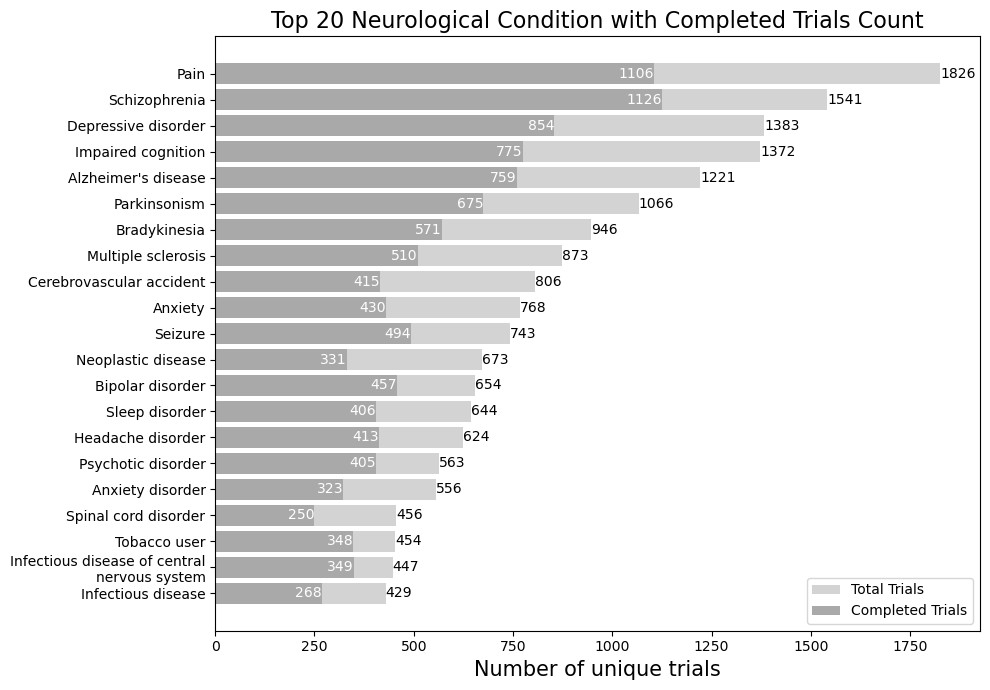

In [45]:
plot_entity_trials(aact_diseases, condition_col_name, 'disease', 'overall_status', 'Completed', annotations_type, viz_path_diseases, top_n=20)


## Disease/ Phase

In [46]:
# Aggregate trials by disease and phase, counting unique nct_ids
disease_phase_counts = aact_diseases.groupby([condition_col_name, 'phase'])['nct_id'].nunique().reset_index()

# Pivot the data to have diseases as rows and phases as columns, filling missing values with 0
pivot_df = disease_phase_counts.pivot(index=condition_col_name, columns='phase', values='nct_id').fillna(0)

# Calculate total trials per disease to identify the top 20 diseases
pivot_df['Total Trials'] = pivot_df.sum(axis=1)
top_20_diseases = pivot_df.sort_values('Total Trials', ascending=False).head(21)
top_20_diseases

phase                                          Early Phase 1  Not Applicable  \
Neurological Condition                                                         
Pain                                                    35.0           484.0   
Schizophrenia                                           16.0           197.0   
Depressive disorder                                     41.0           344.0   
Impaired cognition                                      39.0           205.0   
Alzheimer's disease                                     39.0           106.0   
Parkinsonism                                            20.0           109.0   
Bradykinesia                                            20.0           107.0   
Multiple sclerosis                                      14.0            83.0   
Cerebrovascular accident                                13.0           176.0   
Anxiety                                                 23.0           179.0   
Seizure                                                  7.0           108.0   
Neoplastic disease                                      34.0           122.0   
Bipolar disorder                                         8.0            85.0   
Sleep disorder                                          13.0           116.0   
Headache disorder                                        5.0           133.0   
Psychotic disorder                                       9.0            86.0   
Anxiety disorder                                        17.0            90.0   
Spinal cord disorder                                    13.0            62.0   
Tobacco user                                            18.0           127.0   
Infectious disease of central\nnervous system            6.0            31.0   
Surgical procedure                                       5.0           160.0   

phase                                          Phase 1  Phase 1/Phase 2  \
Neurological Condition                                                    
Pain                                              90.0             50.0   
Schizophrenia                                    243.0             37.0   
Depressive disorder                              115.0             34.0   
Impaired cognition                               206.0             68.0   
Alzheimer's disease                              332.0             62.0   
Parkinsonism                                     220.0             62.0   
Bradykinesia                                     132.0             63.0   
Multiple sclerosis                               115.0             60.0   
Cerebrovascular accident                          58.0             35.0   
Anxiety                                           33.0             24.0   
Seizure                                           96.0             21.0   
Neoplastic disease                               111.0             58.0   
Bipolar disorder                                  39.0             13.0   
Sleep disorder                                    27.0             23.0   
Headache disorder                                 75.0             14.0   
Psychotic disorder                                54.0             10.0   
Anxiety disorder                                  38.0             17.0   
Spinal cord disorder                              67.0             49.0   
Tobacco user                                      47.0             18.0   
Infectious disease of central\nnervous system     30.0             14.0   
Surgical procedure                                10.0             13.0   

phase                                          Phase 2  Phase 2/Phase 3  \
Neurological Condition                                                    
Pain                                             359.0             68.0   
Schizophrenia                                    277.0             40.0   
Depressive disorder                              262.0             47.0   
Impaired cognition                               402.0    

In [47]:
def plot_phase_distribution(data, entity_column, entity_type, phase_column, nct_id_column, annotations_type, viz_path, top_n=20):
    """
    Generates a horizontal bar chart for the phase distribution within top entities (e.g., diseases) 
    and saves it to a specified path.

    Parameters:
    data (pd.DataFrame): The input dataframe containing entity, phase, and nct_id columns.
    entity_column (str): The column name in the dataframe representing the entities (e.g., diseases).
    phase_column (str): The column name representing the phases of the trials.
    nct_id_column (str): The column name representing the unique trial IDs.
    annotations_type (str): A string to specify the type of annotations for the title and filename.
    viz_path (Path or str): The path where the plot image will be saved.
    top_n (int): The number of top entities to display in the chart. Default is 20.
    """
    # Step 1: Count total trials per entity per phase
    entity_phase_counts = data.groupby([entity_column, phase_column])[nct_id_column].nunique().reset_index()
    
    # Step 2: Pivot the filtered data to have entities as rows and phases as columns, filling missing values with 0
    pivot_df_filtered = entity_phase_counts.pivot(index=entity_column, columns=phase_column, values=nct_id_column).fillna(0)
    
    # Step 3: Calculate total trials per entity to identify the top N entities
    pivot_df_filtered['Total Trials'] = pivot_df_filtered.sum(axis=1)
    top_entities_filtered = pivot_df_filtered.sort_values('Total Trials', ascending=False).head(top_n)
    
    # Step 4: Drop the 'Total Trials' column as it's no longer needed for plotting
    top_entities_filtered = top_entities_filtered.drop(columns='Total Trials')
    
    # Step 5: Normalize phase counts to proportions within each entity
    normalized_phases_filtered = top_entities_filtered.div(top_entities_filtered.sum(axis=1), axis=0) * 100
    
    # Step 6: Reverse the row order of normalized_phases to have the largest on top
    normalized_phases_filtered_reversed = normalized_phases_filtered.iloc[::-1]
    
    # Convert the DataFrame to a numpy array for easier iteration in plotting
    data_array = normalized_phases_filtered_reversed.to_numpy()
    
    # The y-axis positions for each entity
    y_positions = np.arange(len(normalized_phases_filtered_reversed))
    
    # Setting up the plot
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Colors for each phase, assuming a limited number of phases
    colors = plt.cm.viridis(np.linspace(0, 1, normalized_phases_filtered_reversed.shape[1]))
    
    # Cumulative array to keep track of where to start the next bar segment
    cumulative = np.zeros(len(normalized_phases_filtered_reversed))
    
    for i, (phase_name, color) in enumerate(zip(normalized_phases_filtered_reversed.columns, colors)):
        # The height of the bar for this phase
        phase_data = data_array[:, i]
        
        # Plotting the bar segment
        if phase_name == 'Not Applicable':
            ax.barh(y_positions, phase_data, color='grey', left=cumulative, edgecolor='none', label=phase_name)
        else:
            ax.barh(y_positions, phase_data, color=color, left=cumulative, edgecolor='none', label=phase_name)
        
        # Updating the cumulative sum for the next bar segment
        cumulative += phase_data
        
        # Adding text labels within each bar segment
        for y, (x_position, width) in enumerate(zip(cumulative, phase_data)):
            if width > 0:  # Only add labels for visible segments
                label_color = 'black' if phase_name in ['Phase 3', 'Phase 4'] else 'white'
                label = f'{width:.0f}%'
                ax.text(x_position - width / 2, y, label, va='center', ha='center', color=label_color, fontsize=8)
    
    # Setting the y-ticks to correspond to entities
    ax.set_yticks(y_positions)
    ax.set_yticklabels(normalized_phases_filtered_reversed.index)
    plt.tick_params(axis='y', labelsize=13)
    plt.tick_params(axis='x', labelsize=13)
    
    plt.xlabel('Proportion (%)', fontsize=15)
    plt.title(f'Phase Distribution within Top {top_n} {entity_column} (Normalized to 100%)', fontsize=16)
    plt.legend(title='Phase', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(viz_path / f'{entity_type}_phase_proportions_{annotations_type}.png')
    
    plt.show()

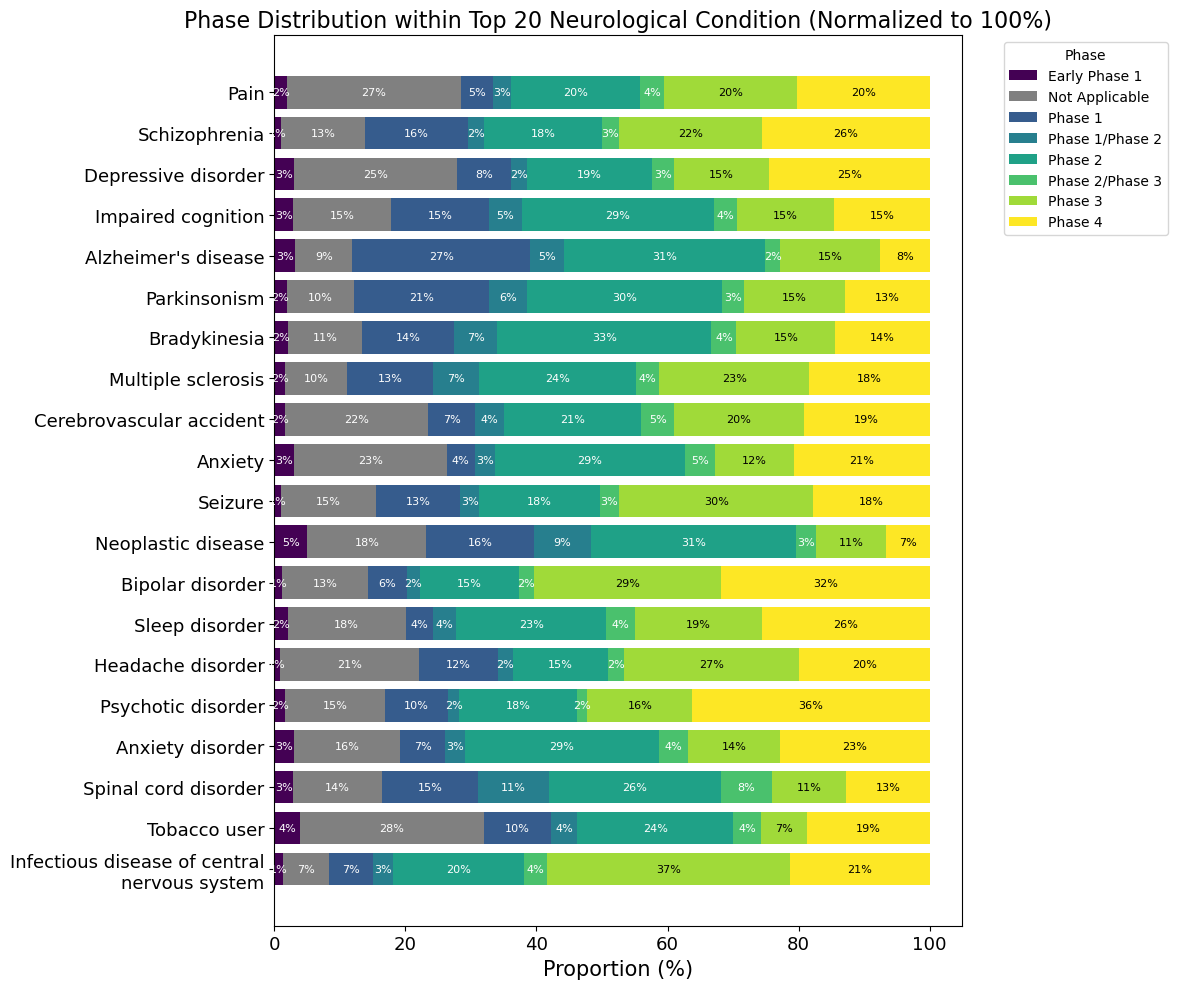

In [48]:
plot_phase_distribution(aact_diseases, condition_col_name, "disease", 'phase', 'nct_id', annotations_type, viz_path_diseases, top_n=20)


## Disease/ Time

In [49]:
def plot_distribution_over_time(data, entity_column, entity_type, year_column, nct_id_column, annotations_type, viz_path, top_n=10, save_to='pdf'):
    """
    Generates a line chart showing the distribution of top entities (e.g., diseases) over start years 
    and saves it to a specified path.

    Parameters:
    data (pd.DataFrame): The input dataframe containing entity, start year, and nct_id columns.
    entity_column (str): The column name in the dataframe representing the entities (e.g., diseases).
    year_column (str): The column name representing the start year of the trials.
    nct_id_column (str): The column name representing the unique trial IDs.
    annotations_type (str): A string to specify the type of annotations for the title and filename.
    viz_path (Path or str): The path where the plot image will be saved.
    top_n (int): The number of top entities to display in the chart. Default is 10.
    """
    # Step 1: Keeping only unique nct_id, entity pairs
    unique_pairs = data[[nct_id_column, entity_column]].drop_duplicates()
    
    # Step 2: Counting the number of nct_ids per entity type and selecting the top N
    entity_counts = unique_pairs[entity_column].value_counts().sort_values(ascending=False).head(top_n)
    
    # Step 3: Filter data to include only the top N entities
    data_top_entities = data[data[entity_column].isin(entity_counts.index)]
    data_top_entities = data_top_entities[[nct_id_column, entity_column, year_column]].drop_duplicates()
    
    # Step 4: Group by start year and entity, count occurrences, and unstack to pivot entities as columns
    grouped = data_top_entities.groupby([year_column, entity_column]).size().unstack(fill_value=0)

    print(entity_counts)
    
    # Step 5: Plot the line chart
    ax = grouped.plot(kind='line', marker='o', figsize=(12, 8))
    
    # Set the title and labels
    plt.title(f'Unique trials for Top {top_n} {entity_column} over Start Year',fontsize=15)
    plt.xlabel('Start Year', fontsize=15)
    #plt.ylabel('Trials Count', fontsize=15)

        # Sorting the legend handles
    handles, labels = ax.get_legend_handles_labels()
    sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: entity_counts[x[1]], reverse=True)
    sorted_handles, sorted_labels = zip(*sorted_handles_labels)
    plt.legend(sorted_handles, sorted_labels, fontsize=15, loc='upper left')
    

    # Adjusting the tick size
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Show the plot
    #plt.legend(fontsize=15, loc='upper left')
    plt.grid(linestyle='--', alpha=0.6, zorder=1)
    plt.tight_layout()
    
    plt.savefig(viz_path / f"{entity_type}_over_time_{annotations_type}_top_{top_n}.{save_to}")
    plt.show()

In [50]:
def plot_stacked_over_time(data, entity_column, entity_type, year_column, nct_id_column, annotations_type, viz_path, top_n=10, save_to='pdf', custom_palette=None):
    """
    Generates a stacked bar chart showing the distribution of top entities (e.g., diseases) over start years 
    and saves it to a specified path.

    Parameters:
    data (pd.DataFrame): The input dataframe containing entity, start year, and nct_id columns.
    entity_column (str): The column name in the dataframe representing the entities (e.g., diseases).
    year_column (str): The column name representing the start year of the trials.
    nct_id_column (str): The column name representing the unique trial IDs.
    annotations_type (str): A string to specify the type of annotations for the title and filename.
    viz_path (Path or str): The path where the plot image will be saved.
    top_n (int): The number of top entities to display in the chart. Default is 10.
    custom_palette (list): A list of colors to use for the bars. Default is None.
    save_to (str): The file format to save the plot. Default is 'pdf'.
    """
    # Step 1: Keeping only unique nct_id, entity pairs
    unique_pairs = data[[nct_id_column, entity_column]].drop_duplicates()
    
    # Step 2: Counting the number of nct_ids per entity type and selecting the top N
    entity_counts = unique_pairs[entity_column].value_counts().sort_values(ascending=False).head(top_n)
    
    # Step 3: Filter data to include only the top N entities
    data_top_entities = data[data[entity_column].isin(entity_counts.index)]
    data_top_entities = data_top_entities[[nct_id_column, entity_column, year_column]].drop_duplicates()
    
    # Step 4: Group by start year and entity, count occurrences, and unstack to pivot entities as columns
    grouped = data_top_entities.groupby([year_column, entity_column]).size().unstack(fill_value=0)
    
    # Step 5: Normalize the counts to get proportions
    grouped_proportions = grouped.div(grouped.sum(axis=1), axis=0)
    
    # Step 6: Sort the columns based on the total count of each disease
    grouped_proportions = grouped_proportions[entity_counts.index]

    # Step 7: Plot the stacked bar chart
    ax = grouped_proportions.plot(kind='bar', stacked=True, figsize=(10, 8), color=custom_palette, zorder=2)

    # Set the title and labels
    plt.title(f'Proportion of Trials for Top {top_n} {entity_column} over Start Year', fontsize=15)
    plt.xlabel('Start Year', fontsize=15)
    #plt.ylabel('Proportion of Trials', fontsize=15)

    # Add labels to each segment
    for bars in ax.containers:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{height:.0%}', ha='center', va='center', fontsize=10, rotation=90)

    # Sorting the legend handles and bars
    handles, labels = ax.get_legend_handles_labels()
    sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: entity_counts[x[1]])
    sorted_handles, sorted_labels = zip(*sorted_handles_labels)  # Reverse the order
    plt.legend(sorted_handles, sorted_labels, fontsize=12, loc='upper left', bbox_to_anchor=(1.00, 1))

    # Adjusting the tick size and labels
    plt.xticks(ticks=range(0, len(grouped_proportions.index), 5), labels=[int(year) for year in grouped_proportions.index[::5]], fontsize=15, rotation=0)
    plt.yticks(fontsize=14)

    # Set y-axis limits and labels
    ax.set_ylim(0, 1)
    ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()])

    # Show the plot
    plt.grid(linestyle='--', alpha=0.6, zorder=1)
    plt.tight_layout()
    
    plt.savefig(viz_path / f"{entity_type}_over_time_{annotations_type}_top_{top_n}_stacked.{save_to}")
    plt.show()

In [51]:
def plot_stacked_over_time_global_totals(data, entity_column, entity_type, year_column, nct_id_column, annotations_type, viz_path, top_n=10, save_to='pdf', custom_palette=None):
    """
    Generates a stacked bar chart showing the distribution of top entities (e.g., diseases) over start years 
    and saves it to a specified path.

    Parameters:
    data (pd.DataFrame): The input dataframe containing entity, start year, and nct_id columns.
    entity_column (str): The column name in the dataframe representing the entities (e.g., diseases).
    year_column (str): The column name representing the start year of the trials.
    nct_id_column (str): The column name representing the unique trial IDs.
    annotations_type (str): A string to specify the type of annotations for the title and filename.
    viz_path (Path or str): The path where the plot image will be saved.
    top_n (int): The number of top entities to display in the chart. Default is 10.
    custom_palette (list): A list of colors to use for the bars. Default is None.
    save_to (str): The file format to save the plot. Default is 'pdf'.
    """
    # Step 1: Keeping only unique nct_id, entity pairs
    unique_pairs = data[[nct_id_column, entity_column]].drop_duplicates()
    
    # Step 2: Counting the number of nct_ids per entity type and selecting the top N
    entity_counts = unique_pairs[entity_column].value_counts().sort_values(ascending=False).head(top_n)
    
    # Step 3: Filter data to include only the top N entities
    data_top_entities = data[data[entity_column].isin(entity_counts.index)]
    data_top_entities = data_top_entities[[nct_id_column, entity_column, year_column]].drop_duplicates()
    
    # Step 4: Group by start year and entity, count occurrences, and unstack to pivot entities as columns
    grouped = data_top_entities.groupby([year_column, entity_column]).size().unstack(fill_value=0)
    
    # Step 5: Normalize the counts to get proportions
    yearly_totals = data.groupby(year_column)[nct_id_column].nunique()
    print("yearly totals")
    print(yearly_totals)
    grouped_proportions = grouped.div(yearly_totals, axis=0)
    
    # Step 6: Sort the columns based on the total count of each disease
    grouped_proportions = grouped_proportions[entity_counts.index]

    # Step 7: Plot the stacked bar chart
    ax = grouped_proportions.plot(kind='bar', stacked=True, figsize=(11, 8), color=custom_palette, zorder=2)

    # Set the title and labels
    plt.title(f'Proportion of Trials for Top {top_n} {entity_column} over Start Year', fontsize=15)
    plt.xlabel('Start Year', fontsize=15)
    #plt.ylabel('Proportion of Trials', fontsize=15)

    # Add labels to each segment
    for bars in ax.containers:
        for bar in bars:
            height = bar.get_height()
            if height > 0.03:
                bar_color = bar.get_facecolor()
                # Convert the color to hex format and check if it matches '#332288'
                hex_color = '#{:02x}{:02x}{:02x}'.format(int(bar_color[0]*255), int(bar_color[1]*255), int(bar_color[2]*255))
                label_color = 'white' if ((hex_color.lower() == '#332288') or (hex_color.lower() == '#882255')) else 'black'
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{height:.0%}', ha='center', va='center', fontsize=10, rotation=90, color=label_color)
                #ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{height:.0%}', ha='center', va='center', fontsize=10, rotation=90, color='white')

    # Sorting the legend handles and bars
    handles, labels = ax.get_legend_handles_labels()
    sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: entity_counts[x[1]], reverse=False)
    sorted_handles, sorted_labels = zip(*sorted_handles_labels)
    plt.legend(sorted_handles, sorted_labels, fontsize=14, loc='upper left', bbox_to_anchor=(1.00, 1))

    # Adjusting the tick size and labels
    plt.xticks(ticks=range(0, len(grouped_proportions.index), 5), labels=[int(year) for year in grouped_proportions.index[::5]], fontsize=15, rotation=0)
    plt.yticks(fontsize=14)

    # Set y-axis limits and labels
    ax.set_ylim(0, 1)
    ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()])

    # Show the plot
    plt.grid(linestyle='--', alpha=0.6, zorder=1)
    plt.tight_layout()
    
    plt.savefig(viz_path / f"{entity_type}_over_time_{annotations_type}_top_{top_n}_stacked_totals.{save_to}")
    plt.show()

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_45581/1530534109.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()])


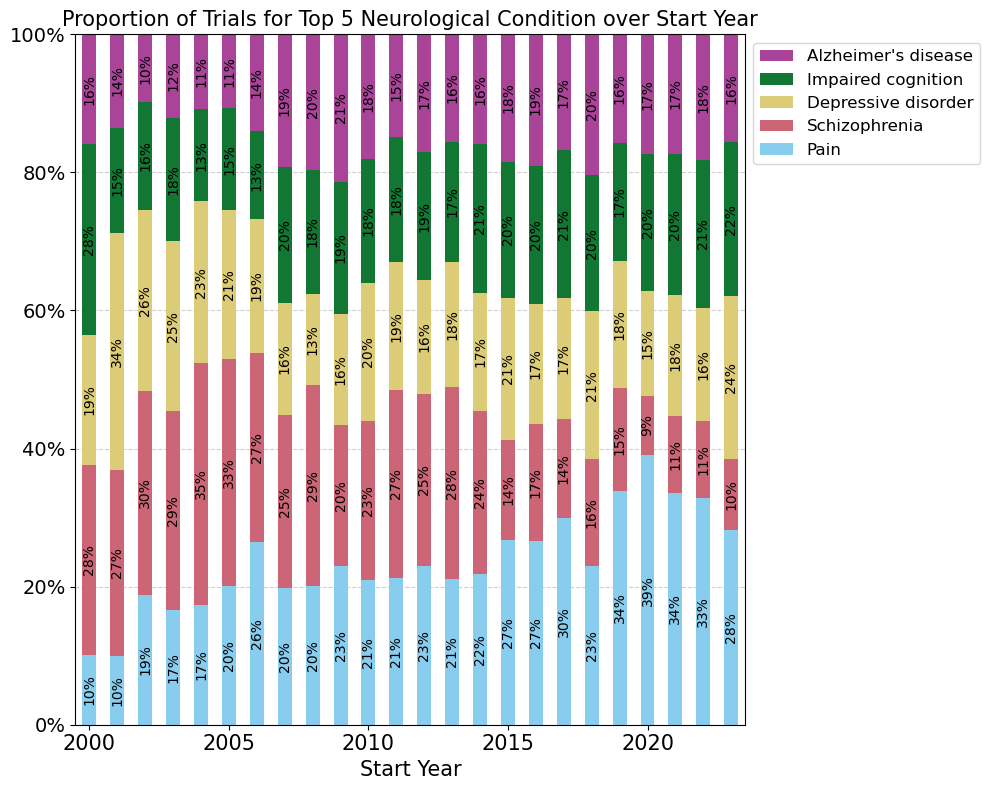

In [52]:
custom_colors = ['#88CCEE', '#CC6677', '#DDCC77', '#117733', '#AA4499', '#44AA99', '#332288', '#882255', '#E69F00', '#D55E00']

plot_stacked_over_time(aact_diseases, condition_col_name, 'disease', 'start_year', 'nct_id', annotations_type, viz_path_diseases, top_n=5, custom_palette = custom_colors)


yearly totals
start_year
2000.0     136
2001.0     235
2002.0     315
2003.0     515
2004.0     660
2005.0     728
2006.0     822
2007.0     813
2008.0     869
2009.0     904
2010.0     865
2011.0     824
2012.0     807
2013.0     773
2014.0     877
2015.0     904
2016.0     862
2017.0     902
2018.0     902
2019.0     964
2020.0     901
2021.0    1078
2022.0    1005
2023.0     948
Name: nct_id, dtype: int64


/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_45581/1695848084.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()])


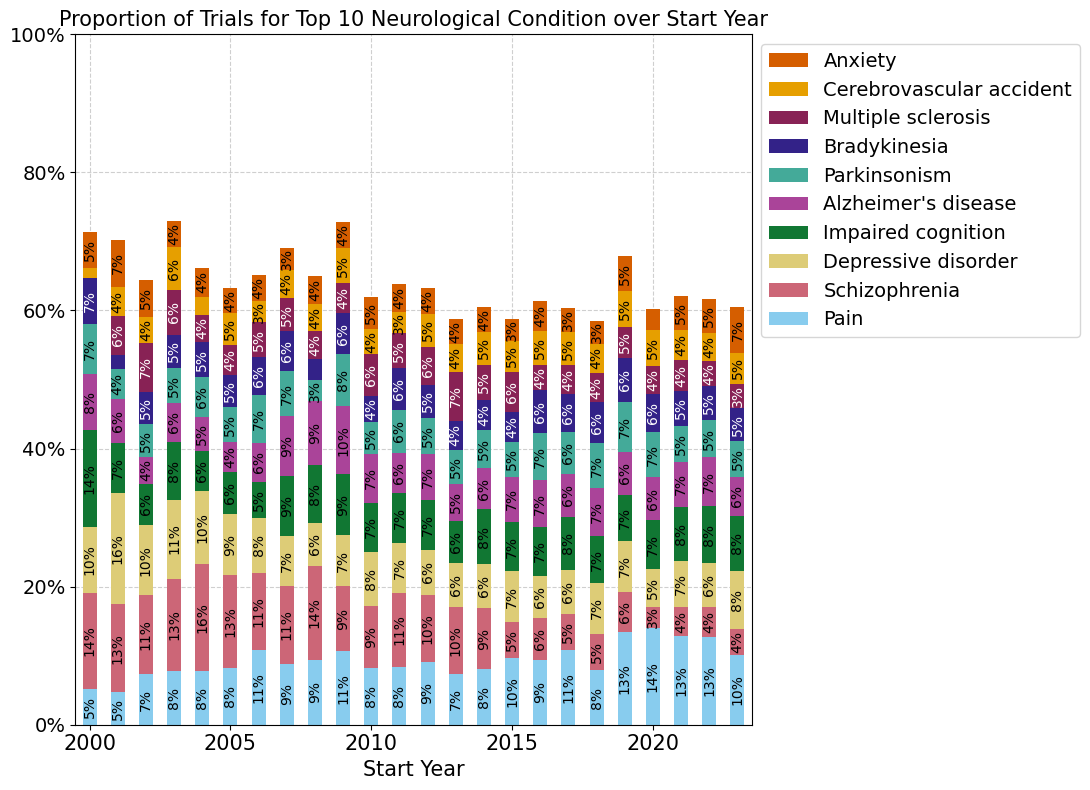

In [53]:
plot_stacked_over_time_global_totals(aact_diseases, condition_col_name, 'disease', 'start_year', 'nct_id', annotations_type, viz_path_diseases, top_n=10, custom_palette = custom_colors)


Neurological Condition
Pain                   1826
Schizophrenia          1541
Depressive disorder    1383
Impaired cognition     1372
Alzheimer's disease    1221
Name: count, dtype: int64


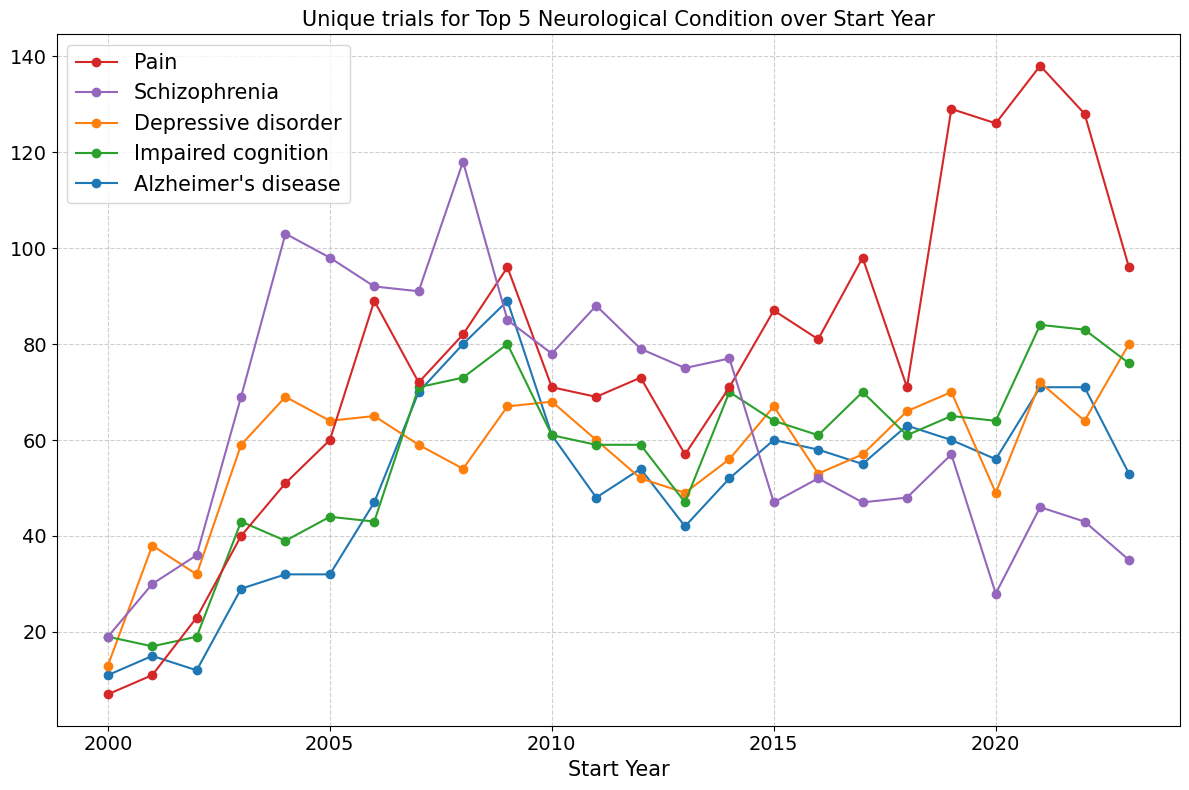

In [54]:
plot_distribution_over_time(aact_diseases, condition_col_name, 'disease', 'start_year', 'nct_id', annotations_type, viz_path_diseases, top_n=5)


## Trends

In [55]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

### Trial Heatmaps

In [56]:
df_unique_trials = aact_diseases[['nct_id', 'Neurological Condition','start_year']].drop_duplicates()
unique_trials_per_year = df_unique_trials.groupby(['Neurological Condition', 'start_year']).size().reset_index(name='unique_trials_count')
unique_trials_per_year = unique_trials_per_year.sort_values(by='unique_trials_count', ascending=True)


In [57]:
# Summing up the unique_trials_count per condition
condition_sums = unique_trials_per_year.groupby("Neurological Condition")["unique_trials_count"].sum().reset_index()

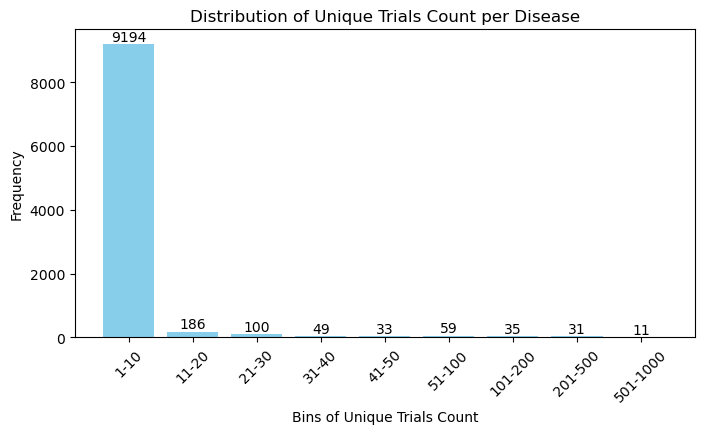

In [58]:
bins = [1, 10, 20, 30, 40, 50, 100, 200, 500, 1000]
labels = ['1-10', '11-20', '21-30', '31-40', '41-50', '51-100', '101-200', '201-500', '501-1000']
condition_sums['binned'] = pd.cut(condition_sums['unique_trials_count'], bins=bins, labels=labels, right=False)
distribution = condition_sums['binned'].value_counts().sort_index()
# Plotting the distribution with counts on the bars

plt.figure(figsize=(8, 4))
bars = plt.bar(distribution.index.astype(str), distribution.values, color='skyblue')

# Adding the count on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, int(yval), ha='center', va='bottom')

plt.xlabel('Bins of Unique Trials Count')
plt.ylabel('Frequency')
plt.title('Distribution of Unique Trials Count per Disease')
plt.xticks(rotation=45)
plt.show()

In [59]:
min_trials = 50

# Filtering the conditions with a total number of trials > 50
filtered_conditions = condition_sums[condition_sums["unique_trials_count"] >= min_trials]

# Keeping only the conditions that meet the criteria in the original dataframe
filtered_df = unique_trials_per_year[unique_trials_per_year["Neurological Condition"].isin(filtered_conditions["Neurological Condition"])]
len(set(filtered_df['Neurological Condition']))

142

In [60]:
# Creating a pivot table with start_years as columns and their counts as values
pivot_df = filtered_df.pivot_table(
    index="Neurological Condition", 
    columns="start_year", 
    values="unique_trials_count", 
    aggfunc='sum', 
    fill_value=0
)

# Reordering the columns from 2000 to 2023
pivot_df = pivot_df.reindex(columns=range(2000, 2024), fill_value=0)

# Resetting index to turn the "Neurological Condition" back into a column
pivot_df.reset_index(inplace=True)
pivot_df

start_year                Neurological Condition  2000  2001  2002  2003  \
0                                     Acromegaly     2     1     4     4   
1                                Acute psychosis     0     1     2     4   
2                            Aggressive behavior     0     1     1     4   
3                                        Alcohol     0     1     1     3   
4                            Alzheimer's disease    11    15    12    29   
..                                           ...   ...   ...   ...   ...   
137         mild-to-moderate alzheimer's disease     0     0     0     0   
138                           motor fluctuations     1     1     1     1   
139                                           ms     0     1     5     2   
140                   neurodegenerative diseases     0     0     0     0   
141                                           pd     0     0     0     2   

start_year  2004  2005  2006  2007  2008  ...  2014  2015  2016  2017  2018  \
0              8     3     8     6     9  ...     5     5     1     3     3   
1              4     6     3     8     7  ...     1     3     1     3     1   
2              1     1     5     1     2  ...     2     5     1     3     4   
3              2     3     2     4     4  ...     4     3     1     4     0   
4             32    32    47    70    80  ...    52    60    58    55    63   
..           ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   
137            2     2     2     3     6  ...     2     2     1     2     1   
138            0     1     6     7     1  ...     4     5     5     3     2   
139            2     4     4    10     3  ...     5    11     6     7     7   
140            0     0     2     1     1  ...     4     1     2     3     3   
141            0     1     6    10     3  ...     8     6     8     5     8   

start_year  2019  2020  2021  2022  2023  
0              7     2     3     1     1  
1              2     2     4     1     2  
2              4     1     1     5     1  
3              0     1     1     1     2  
4             60    56    71    71    53  
..           ...   ...   ...   ...   ...  
137            2     2     3     4     0  
138            6     1     0     0     2  
139            7     6    12     9     3  
140            2     3     8     9    11  
141            8     8     6     6     4  

[142 rows x 25 columns]

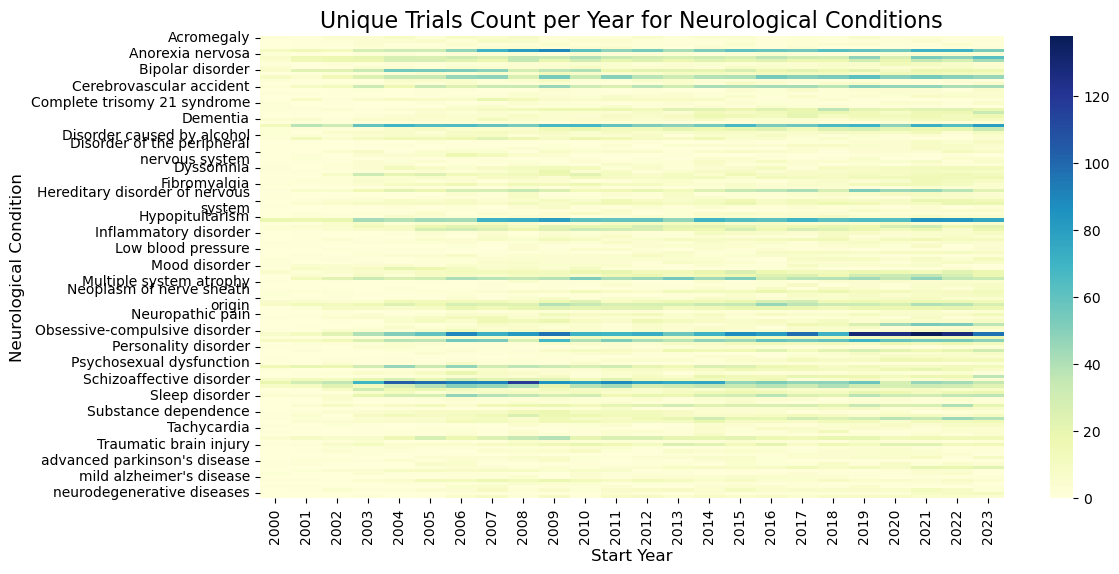

In [62]:
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Create a heatmap with a gradient color coding
heatmap = sns.heatmap(pivot_df.set_index("Neurological Condition"), annot=False, cmap="YlGnBu", cbar=True)

# Customize the heatmap
heatmap.set_title('Unique Trials Count per Year for Neurological Conditions', fontsize=16)
heatmap.set_xlabel('Start Year', fontsize=12)
heatmap.set_ylabel('Neurological Condition', fontsize=12)

# Show the plot
plt.show()

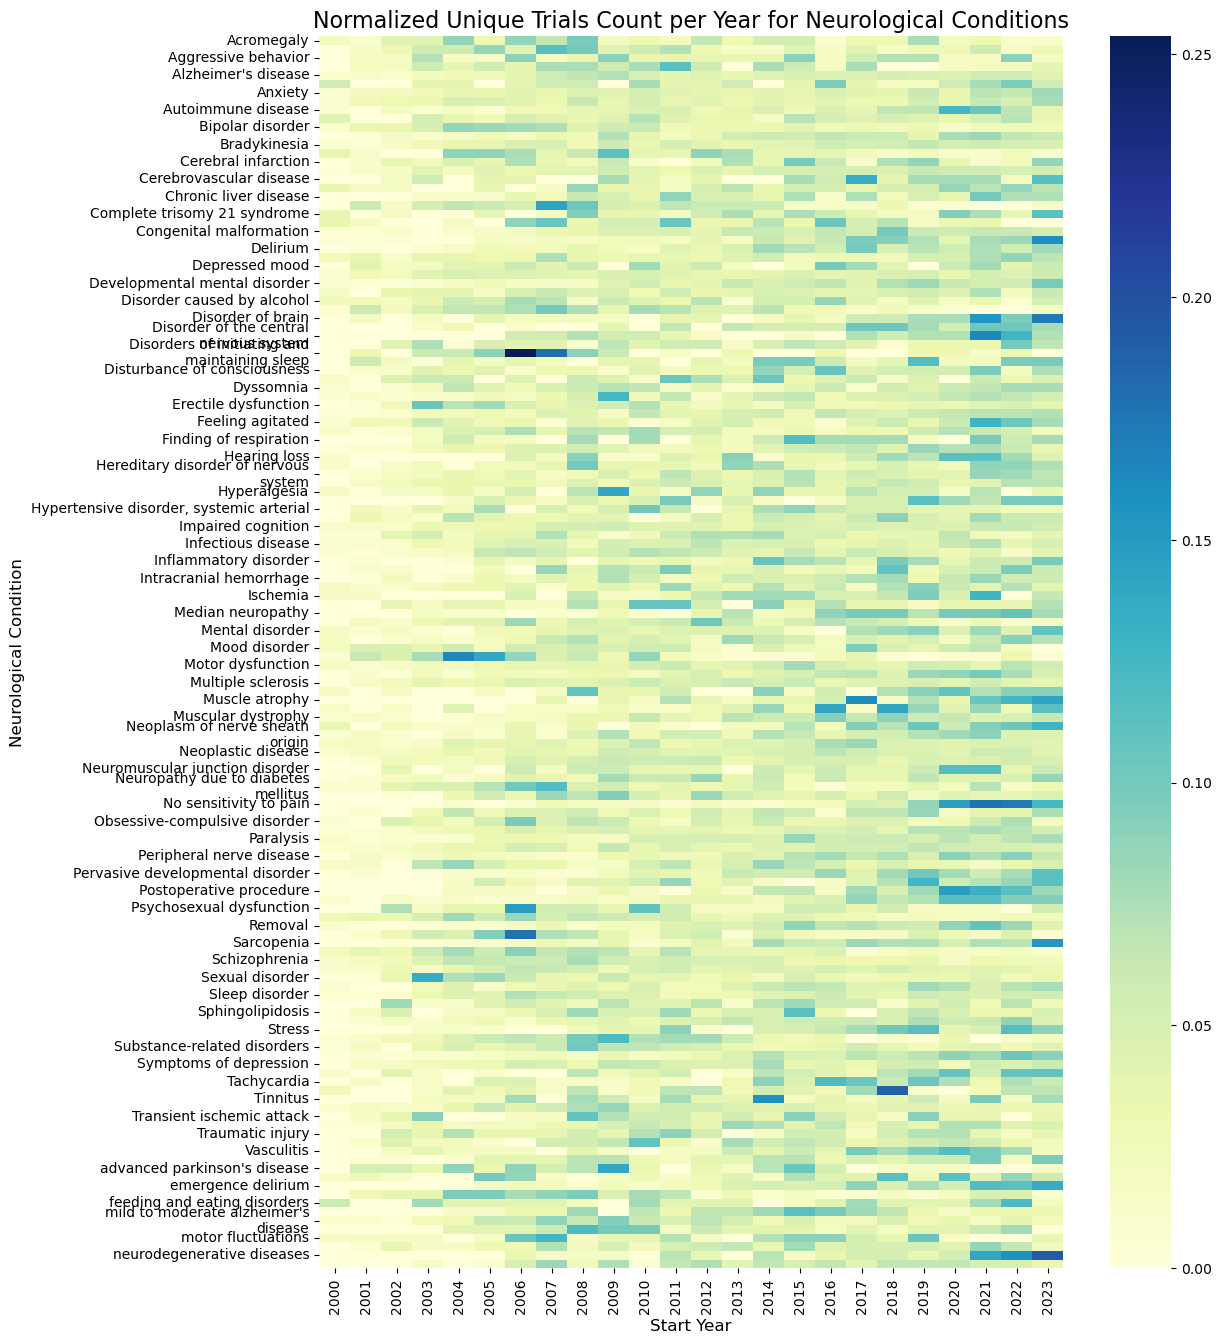

In [63]:
# Normalizing the values row-wise
normalized_pivot_df = pivot_df.set_index("Neurological Condition").div(pivot_df.set_index("Neurological Condition").sum(axis=1), axis=0)

# Set up the matplotlib figure
plt.figure(figsize=(12, 16))

# Create a heatmap with a gradient color coding
heatmap = sns.heatmap(normalized_pivot_df, annot=False, cmap="YlGnBu", cbar=True)

# Customize the heatmap
heatmap.set_title('Normalized Unique Trials Count per Year for Neurological Conditions', fontsize=16)
heatmap.set_xlabel('Start Year', fontsize=12)
heatmap.set_ylabel('Neurological Condition', fontsize=12)

# Show the plot
plt.show()

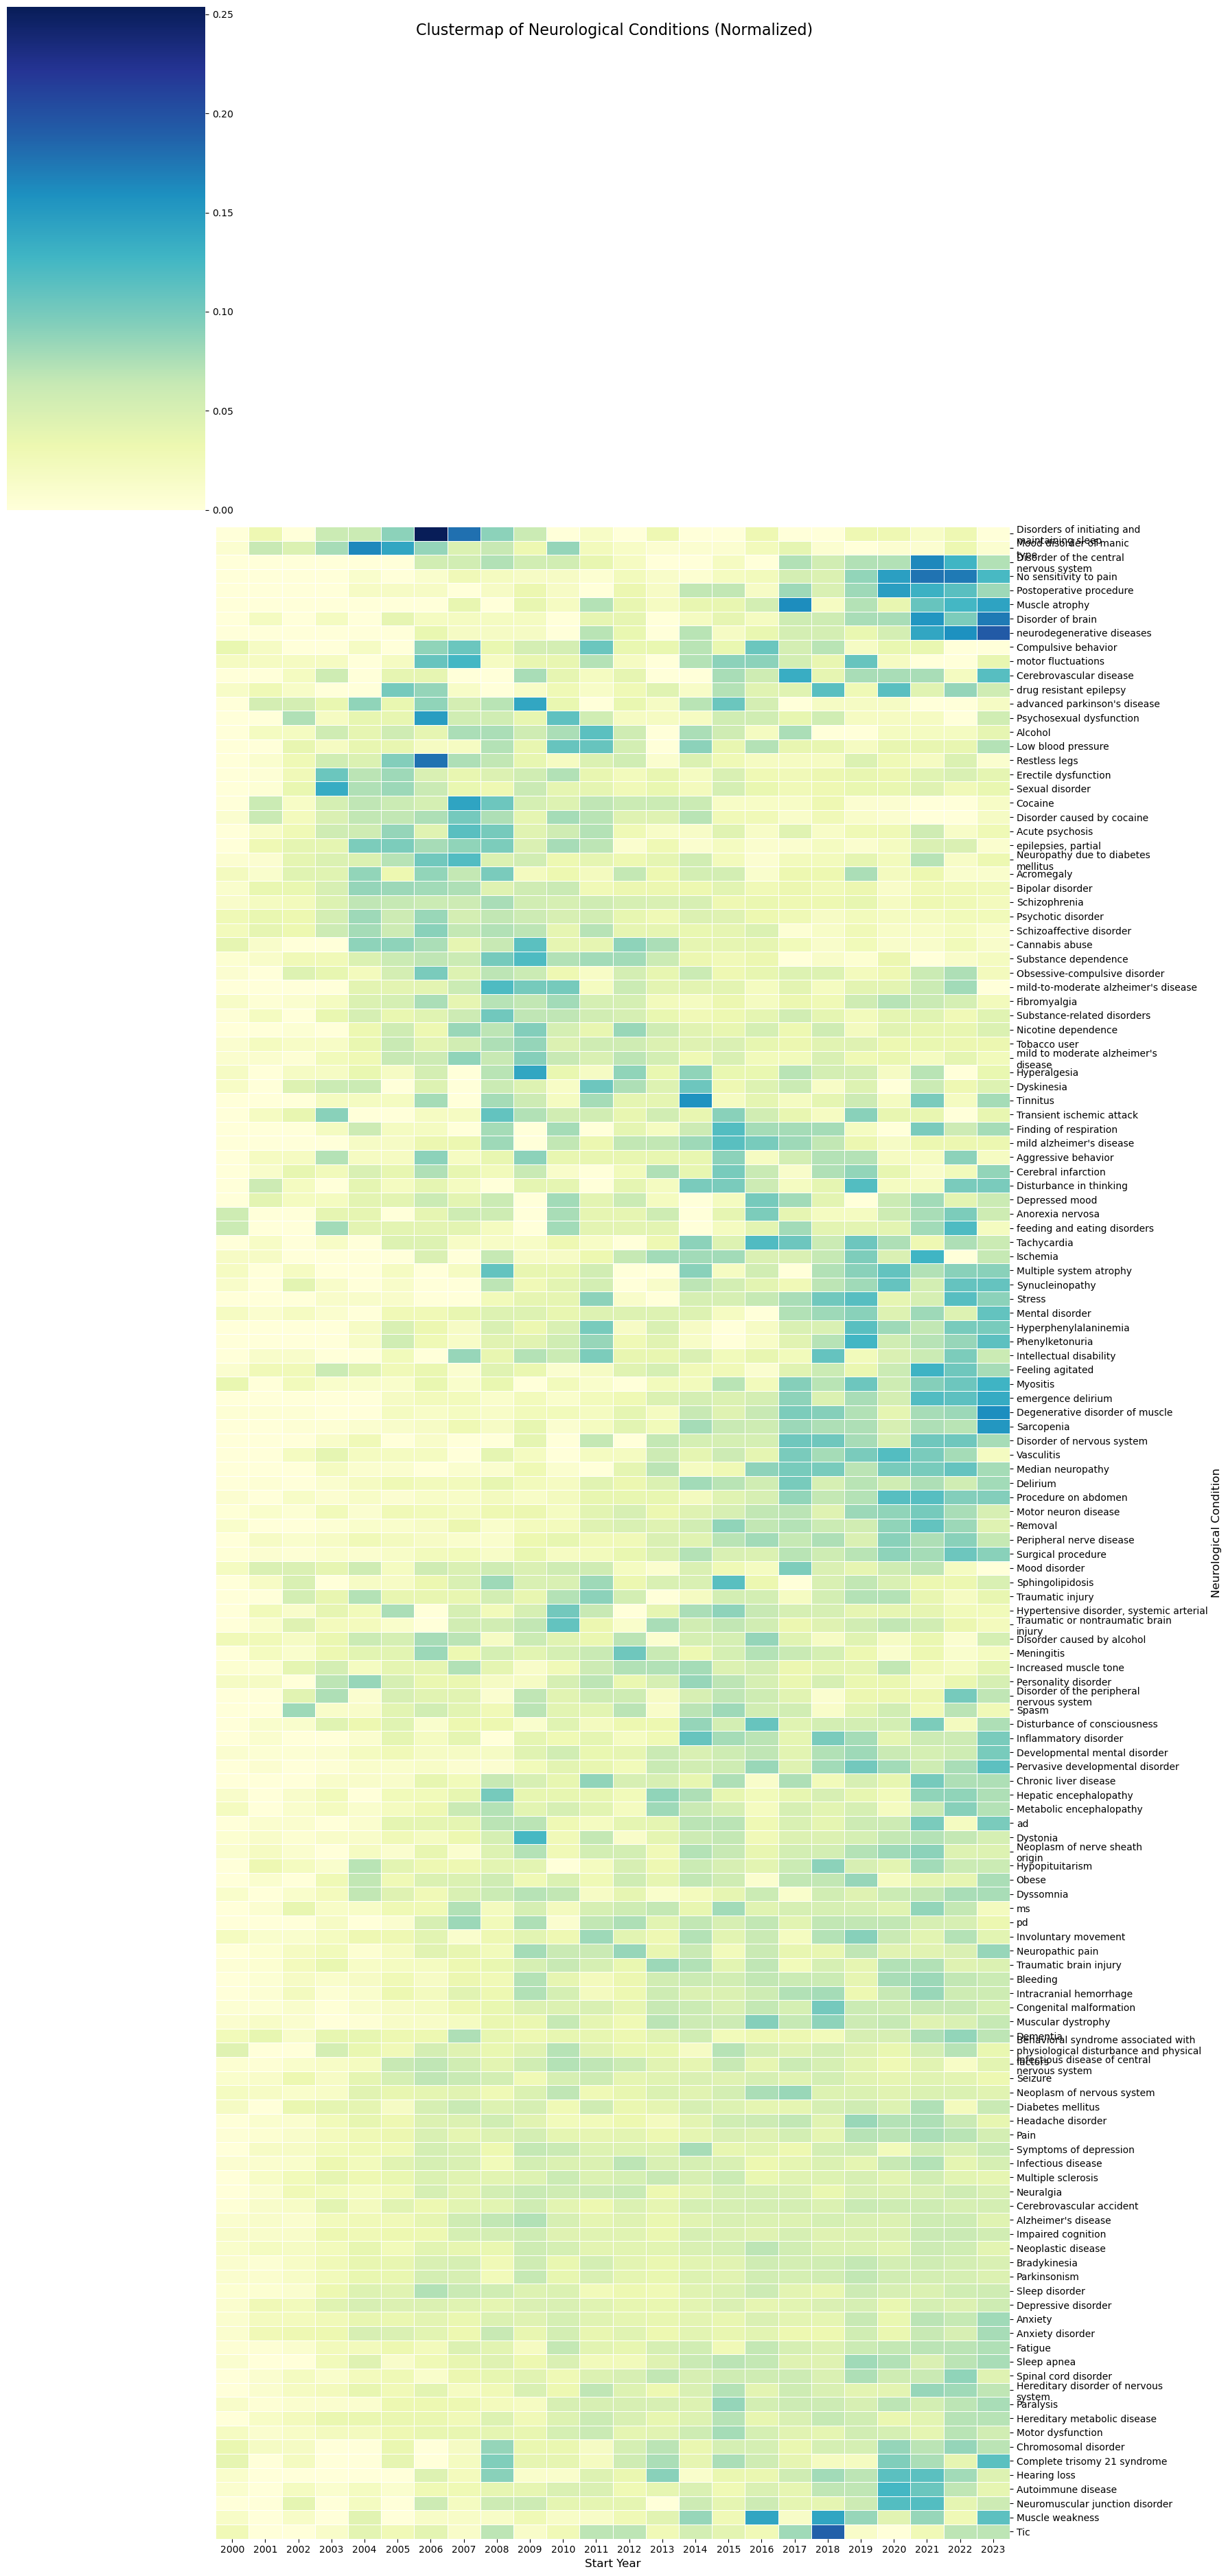

In [64]:
# Using Seaborn's clustermap for hierarchical clustering and heatmap with fixed column order
clustermap_fixed = sns.clustermap(
    normalized_pivot_df,
    #method='average',
    #metric='euclidean',
    cmap='YlGnBu',
    linewidths=.5,
    figsize=(18, 38),
    annot=False,
    cbar=True,
    col_cluster=False, 
)#cbar_kws={'location': 'top'})

# Customize the clustermap
clustermap_fixed.fig.suptitle('Clustermap of Neurological Conditions (Normalized)', fontsize=16)
clustermap_fixed.ax_heatmap.set_xlabel('Start Year', fontsize=12)
clustermap_fixed.ax_heatmap.set_ylabel('Neurological Condition', fontsize=12)

#clustermap_fixed.cax.set_visible(False)
clustermap_fixed.ax_row_dendrogram.set_visible(False)
clustermap_fixed.ax_col_dendrogram.set_visible(False)

plt.tight_layout()
# Show the plot
plt.show()

In [65]:
# Extracting the reordered data from the clustermap
reordered_data = normalized_pivot_df.iloc[clustermap_fixed.dendrogram_row.reordered_ind]

# Saving the reordered data to a CSV file
csv_path = "analysis/trials_trends/reordered_neurological_conditions.csv"
reordered_data.to_csv(csv_path)


In [66]:
reordered_data.head(10)

start_year                                          2000      2001      2002  \
Neurological Condition                                                         
Disorders of initiating and\nmaintaining sleep  0.000000  0.029851  0.000000   
Mood disorder of manic\ntype                    0.007812  0.062500  0.046875   
Disorder of the central\nnervous system         0.000000  0.000000  0.000000   
No sensitivity to pain                          0.000000  0.000000  0.000000   
Postoperative procedure                         0.000000  0.000000  0.000000   
Muscle atrophy                                  0.000000  0.000000  0.000000   
Disorder of brain                               0.000000  0.019231  0.000000   
neurodegenerative diseases                      0.000000  0.000000  0.000000   
Compulsive behavior                             0.035088  0.017544  0.000000   
motor fluctuations                              0.017857  0.017857  0.017857   

start_year                                          2003      2004      2005  \
Neurological Condition                                                         
Disorders of initiating and\nmaintaining sleep  0.059701  0.059701  0.089552   
Mood disorder of manic\ntype                    0.078125  0.164062  0.140625   
Disorder of the central\nnervous system         0.000000  0.000000  0.000000   
No sensitivity to pain                          0.000000  0.010000  0.000000   
Postoperative procedure                         0.000000  0.016393  0.016393   
Muscle atrophy                                  0.000000  0.000000  0.000000   
Disorder of brain                               0.019231  0.000000  0.038462   
neurodegenerative diseases                      0.000000  0.000000  0.000000   
Compulsive behavior                             0.000000  0.017544  0.000000   
motor fluctuations                              0.017857  0.000000  0.017857   

start_year                                          2006      2007      2008  \
Neurological Condition                                                         
Disorders of initiating and\nmaintaining sleep  0.253731  0.179104  0.089552   
Mood disorder of manic\ntype                    0.085938  0.046875  0.062500   
Disorder of the central\nnervous system         0.054545  0.054545  0.072727   
No sensitivity to pain                          0.010000  0.026667  0.020000   
Postoperative procedure                         0.016393  0.000000  0.016393   
Muscle atrophy                                  0.000000  0.035714  0.000000   
Disorder of brain                               0.019231  0.019231  0.019231   
neurodegenerative diseases                      0.035088  0.017544  0.017544   
Compulsive behavior                             0.087719  0.105263  0.035088   
motor fluctuations                              0.107143  0.125000  0.017857   

start_year                                          2009  ...      2014  \
Neurological Condition                                    ...             
Disorders of initiating and\nmaintaining sleep  0.059701  ...  0.000000   
Mood disorder of manic\ntype                    0.031250  ...  0.007812   
Disorder of the central\nnervous system         0.054545  ...  0.000000   
No sensitivity to pain                          0.016667  ...  0.006667   
Postoperative procedure                         0.032787  ...  0.065574   
Muscle atrophy                                  0.035714  ...  0.035714   
Disorder of brain                               0.019231  ...  0.019231   
neurodegenerative diseases                      0.017544  ...  0.070175   
Compulsive behavior                             0.052632  ...  0.070175   
motor fluctuations                              0.035714  ...  0.071429   

start_year                                          2015      2016      2017  \
Neurological Condition                                                         
Disorders of initiating and\nmaintaining sleep  0.000000

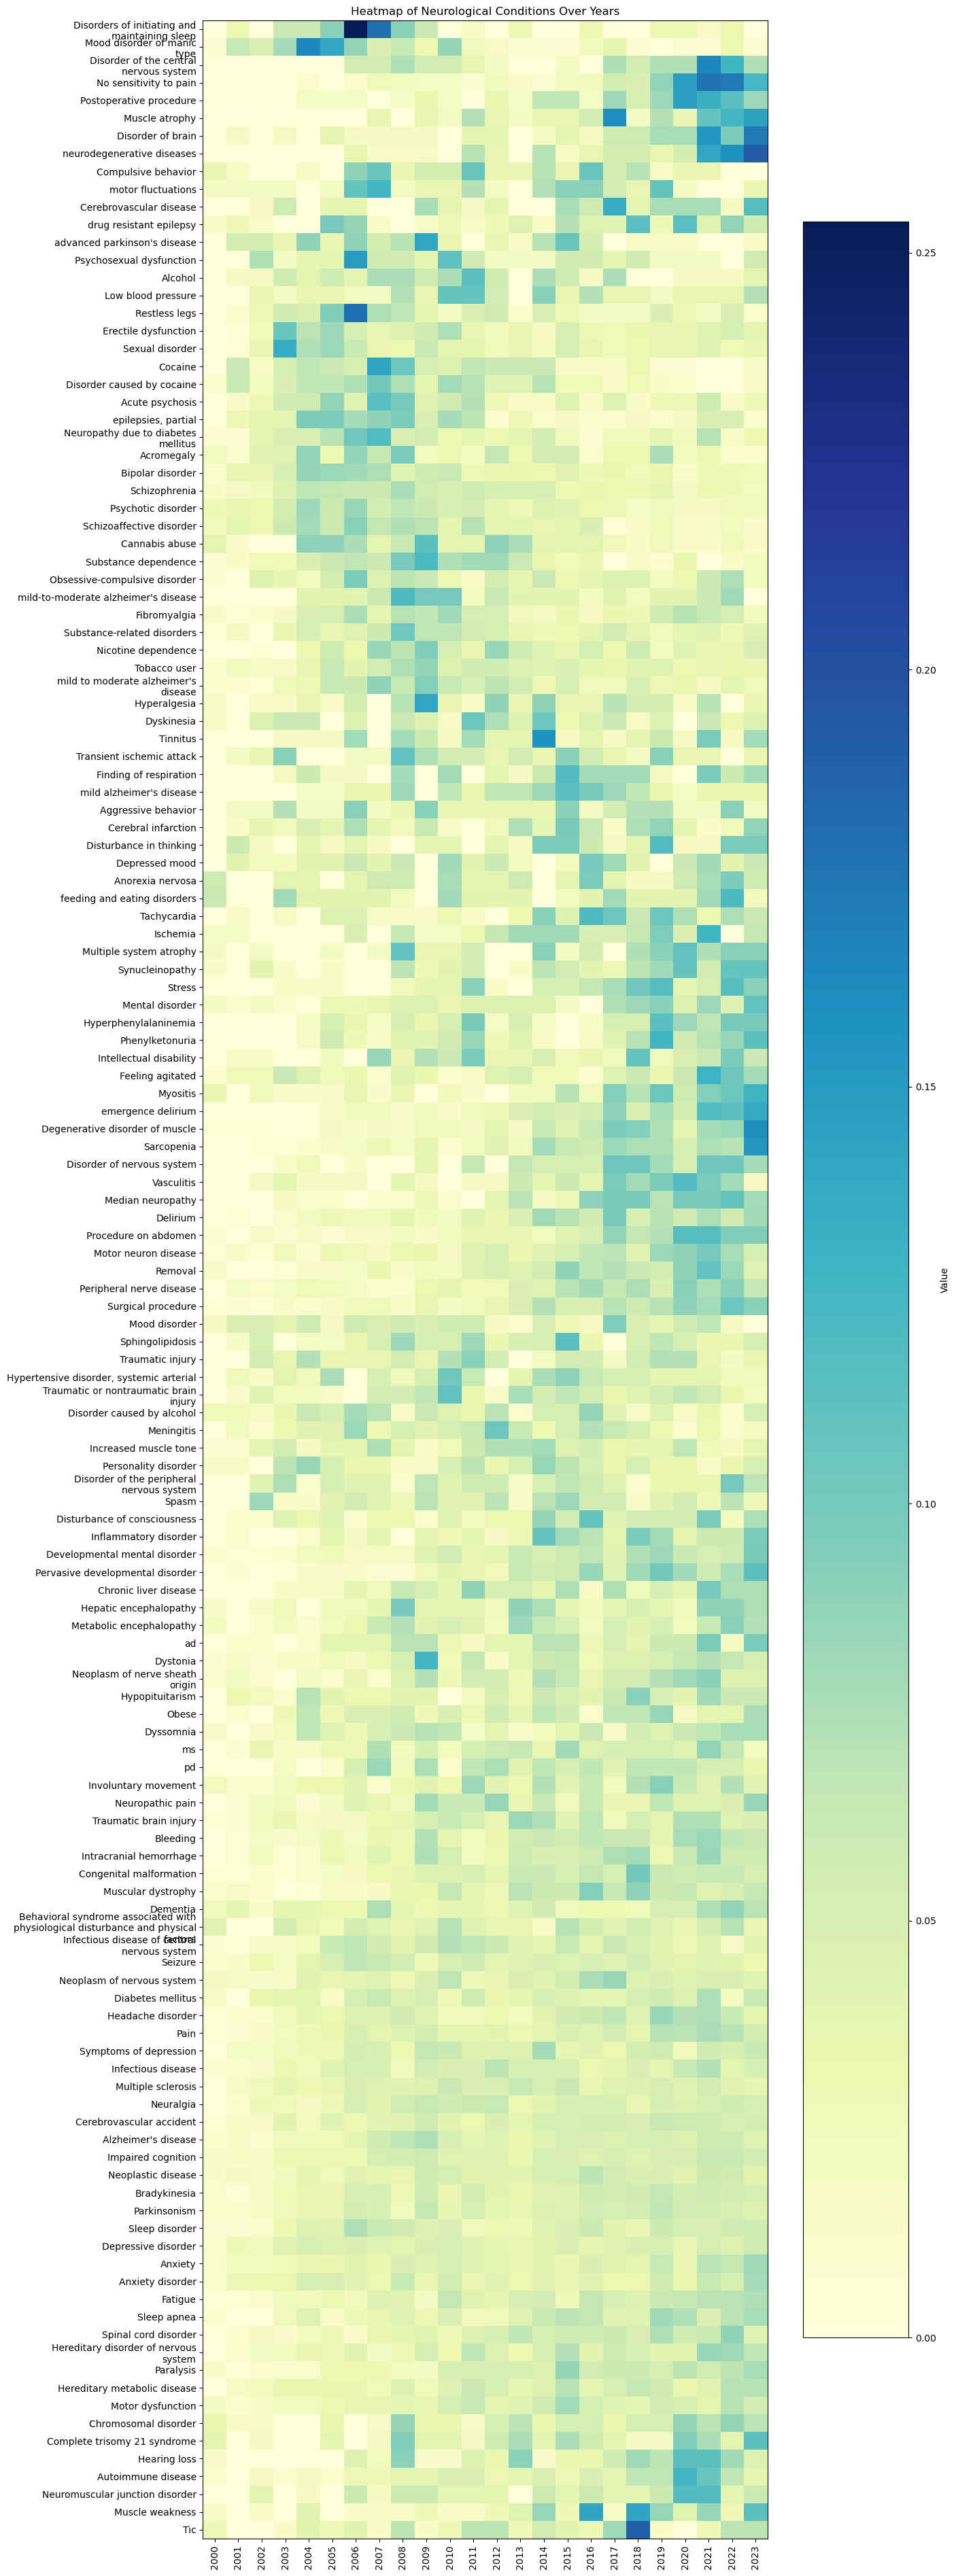

In [67]:
save_to = 'png'
entity_type = 'condition'
df = pd.read_csv("analysis/trials_trends/reordered_neurological_conditions.csv")
# Set 'Neurological Condition' as the index
df.set_index('Neurological Condition', inplace=True)

# Convert the DataFrame to a numpy array of floats
data_array = df.to_numpy().astype(float)

# Create a heatmap using matplotlib with 'YlGnBu' colormap
plt.figure(figsize=(14, 38))
plt.imshow(data_array, cmap='YlGnBu', aspect='auto', interpolation='nearest')
plt.colorbar(label='Value')

# Set the labels for x and y axis
plt.xticks(ticks=np.arange(len(df.columns)), labels=df.columns, rotation=90)
plt.yticks(ticks=np.arange(len(df.index)), labels=df.index)

# Display the heatmap
plt.title('Heatmap of Neurological Conditions Over Years')
plt.tight_layout()
plt.savefig(f"viz/trends/{entity_type}_hetmap_mintrials_{min_trials}_clustered.{save_to}")

plt.show()

### S-Curve or Logistic Function


In [68]:
df_unique_trials = aact_diseases[['nct_id', 'Neurological Condition','start_year']].drop_duplicates()

print(df_unique_trials.shape)
unique_trials_per_year = df_unique_trials.groupby(['Neurological Condition', 'start_year']).size().reset_index(name='unique_trials_count')
unique_trials_per_year = unique_trials_per_year.sort_values(by='unique_trials_count', ascending=True)
print(unique_trials_per_year.shape)

# Step 1: Identify conditions with only one trial count
condition_counts = df_unique_trials['Neurological Condition'].value_counts()
single_entry_conditions = condition_counts[condition_counts <= 5].index
multiple_entry_conditions = condition_counts[condition_counts > 5].index

single_entry_df = unique_trials_per_year[unique_trials_per_year['Neurological Condition'].isin(single_entry_conditions)]
multiple_entry_df = unique_trials_per_year[unique_trials_per_year['Neurological Condition'].isin(multiple_entry_conditions)]

print(single_entry_df.shape, multiple_entry_df.shape)

test_norm = multiple_entry_df.copy()
# Step 2: Apply normalization to the filtered data with multiple entries
test_norm['Normalized Trials'] = test_norm.groupby('Neurological Condition')['unique_trials_count'].transform(
    lambda x: 0 if x.max() == x.min() else (x - x.min()) / (x.max() - x.min())
)
test_norm.head(10)

(56239, 3)
(20821, 3)
(11473, 3) (9348, 3)


Neurological Condition  start_year  unique_trials_count  \
13436                    infantile spasms      2021.0                    1   
13435                    infantile spasms      2020.0                    1   
13451  infarction, middle cerebral artery      2003.0                    1   
13453  infarction, middle cerebral artery      2009.0                    1   
13456  infarction, middle cerebral artery      2013.0                    1   
13460  infarction, middle cerebral artery      2020.0                    1   
13459  infarction, middle cerebral artery      2019.0                    1   
13458  infarction, middle cerebral artery      2017.0                    1   
13457  infarction, middle cerebral artery      2015.0                    1   
13455  infarction, middle cerebral artery      2012.0                    1   

       Normalized Trials  
13436                0.0  
13435                0.0  
13451                0.0  
13453                0.0  
13456                0.0  
13460                0.0  
13459                0.0  
13458                0.0  
13457                0.0  
13455                0.0

In [69]:
len(set(test_norm['Neurological Condition']))

790

In [70]:
test_norm[test_norm['Neurological Condition']=="Pd"]

Empty DataFrame
Columns: [Neurological Condition, start_year, unique_trials_count, Normalized Trials]
Index: []

In [71]:
nan_rows = test_norm[test_norm.isna().any(axis=1)]
nan_rows

Empty DataFrame
Columns: [Neurological Condition, start_year, unique_trials_count, Normalized Trials]
Index: []

Interpretation of S-Curve Parameters

*L (Curve's Maximum Value):*

This parameter represents the upper limit of the S-curve. It indicates the maximum number of trials that the disease is expected to reach in the long term.

*k (Growth Rate):*

This is the most crucial parameter for identifying the diseases growing the most. The growth rate k shows how quickly the number of trials for a disease is increasing.

*t0 (Midpoint):*

The midpoint represents the year at which the number of trials reaches half of its maximum value (L/2).
This can give an indication of when the trials began to increase significantly. It shows the inflection point of the growth.

In [72]:
# Define the logistic function
def logistic_function(t, L, t0, k):
    y = L / (1 + np.exp(-k * (t - t0))) #+ b
    return y

def fit_and_evaluate_sigmoid(df, min_trials=5, use_normalized_trials_count=False):
    # Count the number of trials per condition
    condition_counts = df['Neurological Condition'].value_counts()
    print('Nr of conditions ', len(set(df['Neurological Condition'])))
    # Filter conditions with sufficient data
    sufficient_data_conditions = df[df['Neurological Condition'].isin(condition_counts[condition_counts >= min_trials].index)]
    print(f'Nr of conditions with more than {min_trials} trials', len(set(sufficient_data_conditions['Neurological Condition'])))

    # Group by condition and year, then count the trials
    grouped_data = sufficient_data_conditions.groupby(['Neurological Condition', 'start_year']).size().reset_index(name='unique_trials_count')
    
    # Normalize the number of trials for each condition
    grouped_data['Normalized Trials'] = grouped_data.groupby('Neurological Condition')['unique_trials_count'].transform(
        lambda x: 0 if x.max() == x.min() else (x - x.min()) / (x.max() - x.min())
    )

    results = []

    for condition in grouped_data['Neurological Condition'].unique():
        condition_data = grouped_data[grouped_data['Neurological Condition'] == condition]
        years = condition_data['start_year'].values
        if use_normalized_trials_count:
            trials = condition_data['Normalized Trials'].values
        else:
            trials = condition_data['unique_trials_count'].values

        p0 = [max(trials), np.median(years), 1]

        try:
            popt, _ = curve_fit(logistic_function, years, trials, p0=p0, maxfev=10000)
            L, t0, k = popt
            total_trials = condition_data['unique_trials_count'].sum()
            spearman_corr, _ = spearmanr(years, trials)
 
            results.append({'Disease': condition, 'L': L, 'k': k, 't0': t0, 'Total Trials': total_trials, 'Spearmans coef':spearman_corr})
        except Exception as e:
            print(f"Error fitting logistic function for {condition}: {e}")

    results_df = pd.DataFrame(results)
    return results_df, grouped_data


Error fitting logistic function: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.


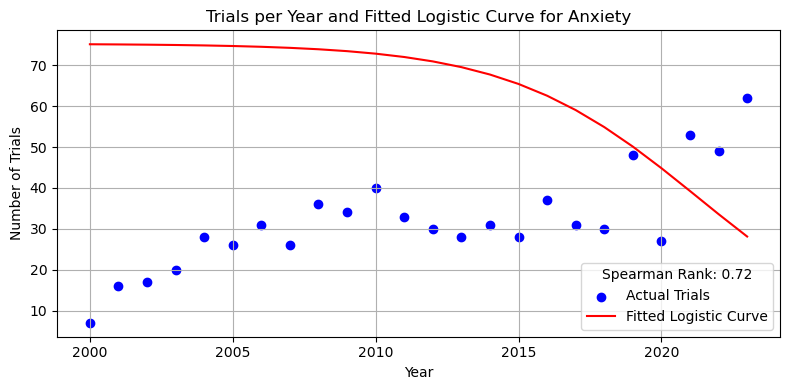

In [78]:
df_unique_trials = aact_diseases[['nct_id', 'Neurological Condition','start_year']].drop_duplicates()

disease_name = 'Anxiety'
# Filter for the specific disease
disease_data = df_unique_trials[df_unique_trials['Neurological Condition'] == disease_name]

# Check if there are enough data points
if len(disease_data) < min_trials:
    print(f"Not enough trials for {disease_name}. At least {min_trials} trials are required.")
    

# Group by year and count the trials
yearly_data = disease_data.groupby('start_year').size().reset_index(name='trials_count')

# Fit the logistic curve
years = yearly_data['start_year'].values
trials = yearly_data['trials_count'].values
# Calculate Spearman rank correlation
spearman_corr, _ = spearmanr(years, trials)
spearman_corr

# Initial parameter guesses
p0 = [max(trials), np.median(years), 1]  # L, t0, k
try:
    popt, _ = curve_fit(logistic_function, years, trials, p0=p0, maxfev=2000)

    L, t0, k = popt
    print(f"L: {L}, t0: {t0}, k: {k}")
except Exception as e:
    print(f"Error fitting logistic function: {e}")
    

# Generate fitted values
fitted_trials = logistic_function(years, *popt)

# Plotting the results
plt.figure(figsize=(8, 4))
plt.scatter(years, trials, color='blue', label='Actual Trials')
plt.plot(years, fitted_trials, color='red', label='Fitted Logistic Curve')
plt.title(f'Trials per Year and Fitted Logistic Curve for {disease_name}')
plt.xlabel('Year')
plt.ylabel('Number of Trials')
plt.legend(title=f"Spearman Rank: {spearman_corr:.2f}")

plt.grid(True)
plt.tight_layout()
plt.savefig(F"viz/trends/conditions_log_regression_{disease_name}.png")
plt.show()

In [79]:
df_unique_trials = aact_diseases[['nct_id', 'Neurological Condition','start_year']].drop_duplicates()

# Fit and evaluate logistic function for all conditions
results_df, unique_trials_per_year = fit_and_evaluate_sigmoid(df_unique_trials, min_trials=50, use_normalized_trials_count = False)
results_df

Nr of conditions  9704
Nr of conditions with more than 50 trials 142


/opt/anaconda3/envs/neurotrial-analysis/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Disease             L         k  \
0                              Acromegaly  4.210445e+00 -1.139240   
1                         Acute psychosis  4.278810e+00 -0.179722   
2                     Aggressive behavior  2.559268e+00  1.790372   
3                                 Alcohol  3.036170e+00 -0.470436   
4                     Alzheimer's disease  6.095796e+01  0.726740   
..                                    ...           ...       ...   
137  mild-to-moderate alzheimer's disease  6.246938e+00 -0.033340   
138                    motor fluctuations  3.295248e+00  0.937377   
139                                    ms  7.517272e+00  0.322294   
140            neurodegenerative diseases  1.089066e+06  0.206666   
141                                    pd  6.583018e+00  4.295793   

              t0  Total Trials  Spearmans coef  
0    2021.379465            92       -0.262079  
1    2018.414121            70       -0.375098  
2    2001.603763            56        0.147601  
3    2020.843121            53       -0.091480  
4    2003.555231          1221        0.593431  
..           ...           ...             ...  
137  2003.384869            50       -0.148105  
138  2003.109767            56        0.381858  
139  2004.377767           138        0.526015  
140  2078.999411            57        0.705742  
141  2005.407691           121        0.151634  

[142 rows x 6 columns]

In [80]:
len(results_df[results_df['Spearmans coef']>0.75])

32

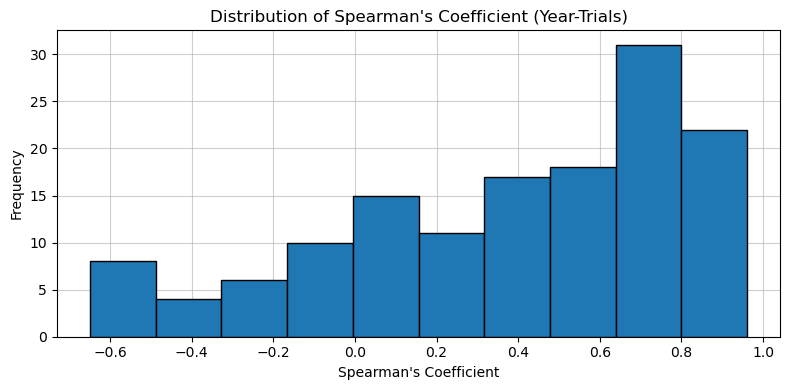

In [81]:
# Plotting the distribution of the Spearman's coefficient column
plt.figure(figsize=(8, 4))
plt.hist(results_df['Spearmans coef'], bins=10, edgecolor='black',zorder=2)
plt.title("Distribution of Spearman's Coefficient (Year-Trials)")
plt.xlabel("Spearman's Coefficient")
plt.ylabel("Frequency")
plt.grid(linestyle='-', alpha=0.6, zorder=0)
plt.tight_layout()
plt.show()

In [82]:
results_df[results_df['Disease']=='Anxiety disorder']

Disease             L        k           t0  Total Trials  \
7  Anxiety disorder  95453.386353  0.02481  2347.585705           556   

   Spearmans coef  
7        0.469594

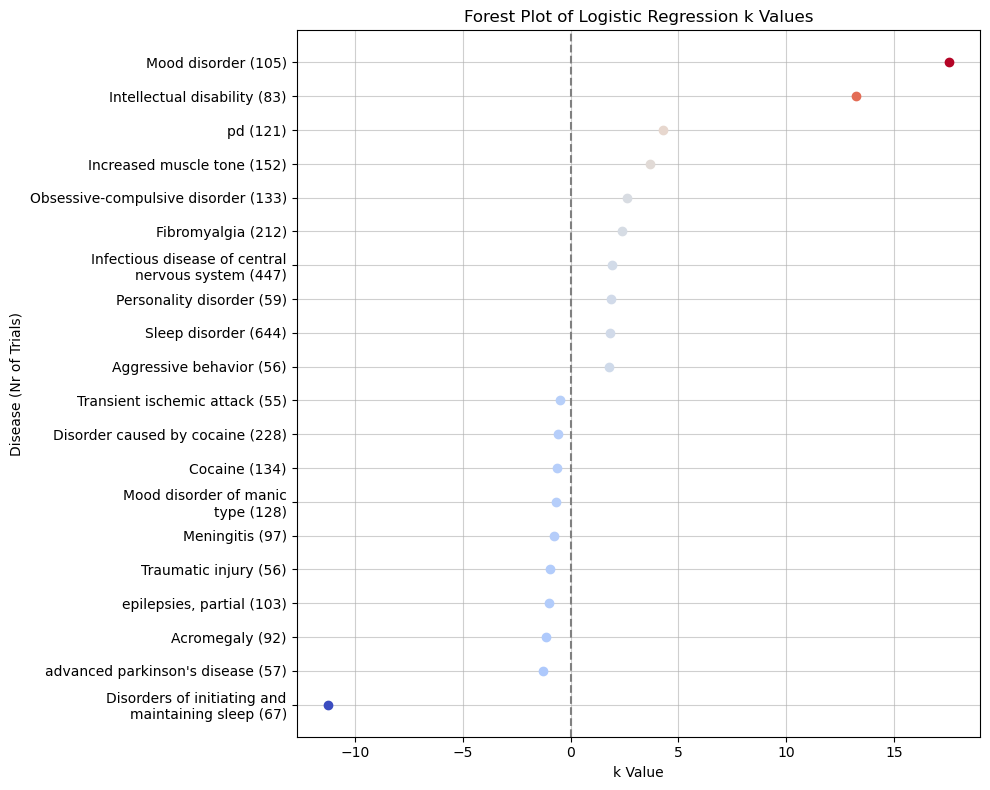

In [83]:
# Sort by k value to find the top 10 highest and lowest
sorted_df = results_df.sort_values(by='k')

# Select the top 10 lowest and top 10 highest k values
top_10_lowest = sorted_df.head(10)
top_10_highest = sorted_df.tail(10)

# Combine the two sets
combined_df = pd.concat([top_10_lowest, top_10_highest])

# Add the number of trials to the disease names
combined_df['Disease (Nr of Trials)'] = combined_df.apply(
    lambda row: f"{row['Disease']} ({row['Total Trials']})", axis=1
)

# Normalize the k values for color mapping
norm = plt.Normalize(combined_df['k'].min(), combined_df['k'].max())
colors = plt.cm.coolwarm(norm(combined_df['k']))

# Create the forest plot
# Create the forest plot
plt.figure(figsize=(10, 8))
for i, (k, disease) in enumerate(zip(combined_df['k'], combined_df['Disease (Nr of Trials)'])):
    plt.errorbar(k, i, xerr=0, fmt='o', color=colors[i])
    
#plt.figure(figsize=(10, 8))
#plt.errorbar(combined_df['k'], combined_df['Disease (Nr of Trials)'], fmt='o', xerr=0, color=colors, ecolor=colors)
plt.axvline(x=0, color='grey', linestyle='--')
plt.yticks(range(len(combined_df)), combined_df['Disease (Nr of Trials)'])

plt.title('Forest Plot of Logistic Regression k Values')
plt.xlabel('k Value')
plt.ylabel('Disease (Nr of Trials)')
plt.grid(linestyle='-', alpha=0.6, zorder=0)
plt.tight_layout()
plt.savefig("viz/trends/conditions_log_regression.png")
plt.show()

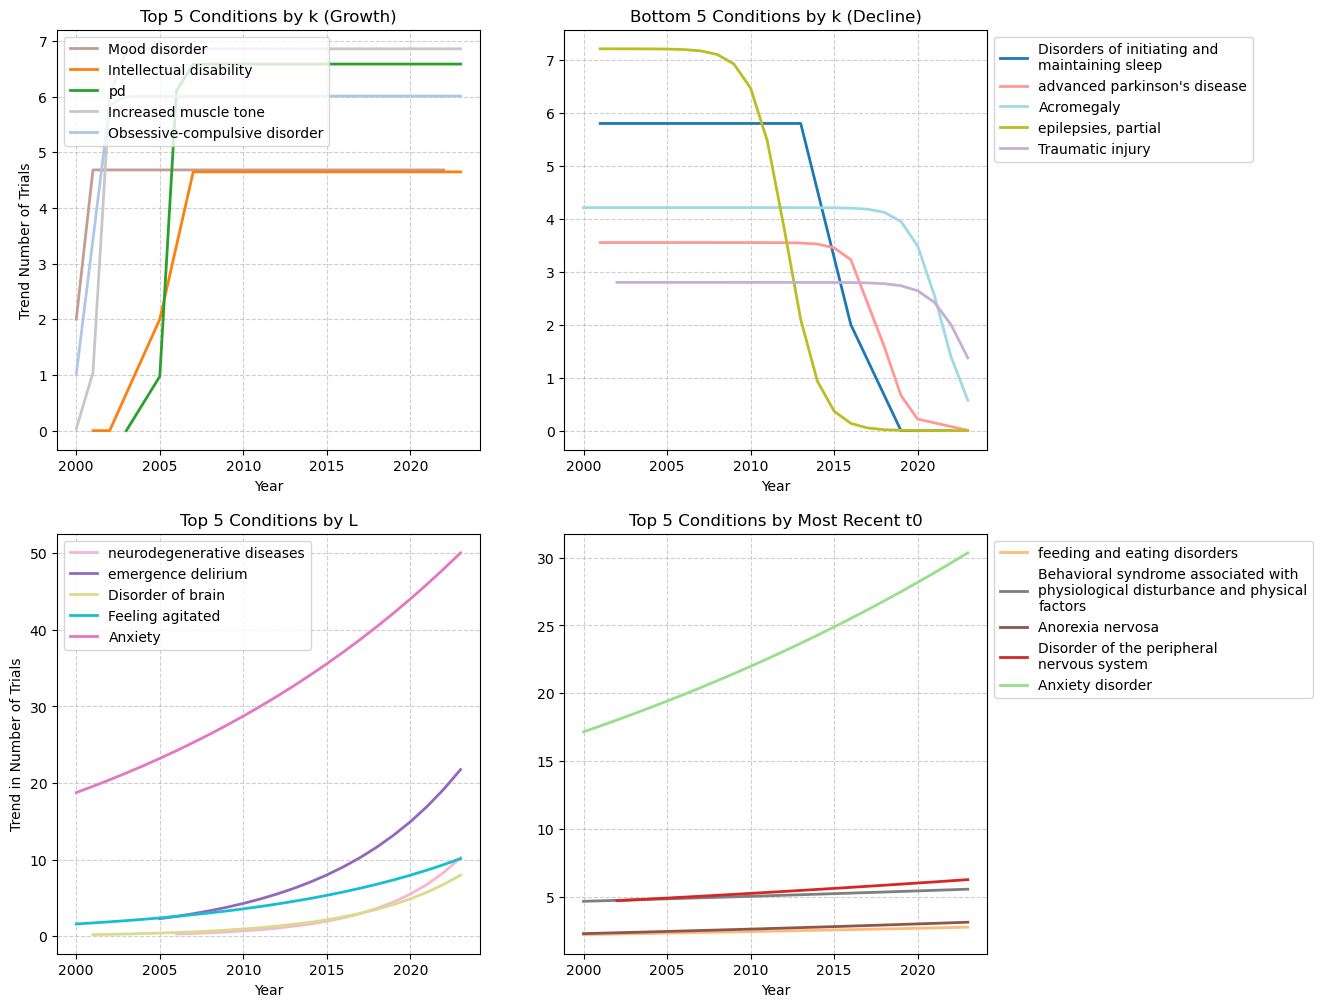

In [84]:
df = unique_trials_per_year.copy()

n_to_plot = 5

# Determine the most interesting trends
# Here we choose top 5 based on highest k, lowest k, highest L, and most recent t0
top_k = results_df.reindex(results_df['k'].nlargest(n_to_plot).index)  # Highest k values
bottom_k = results_df.reindex(results_df['k'].nsmallest(n_to_plot).index)  # Lowest k values (most negative)
top_L = results_df.reindex(results_df['L'].nlargest(n_to_plot).index)  # Highest L values
top_t0 = results_df.reindex(results_df['t0'].nlargest(n_to_plot).index)  # Most recent t0 values

# Gather all unique diseases from your filtered results
unique_diseases = set(top_k['Disease']).union(bottom_k['Disease'], top_L['Disease'], top_t0['Disease'])

# Custom color list provided
custom_colors = [
    "#000000", "#004949", "#009292", "#ff6db6", "#ffb6db",
    "#490092", "#006ddb", "#b66dff", "#6db6ff", "#b6dbff",
    "#920000", "#924900", "#db6d00", "#24ff24", "#ffff6d"
]

# Generate a colorblind-friendly color map
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_diseases)))  # Set2 provides distinct, colorblind-friendly colors
color_map = dict(zip(unique_diseases, colors))

# Create a color map with cycling through the custom colors
#color_map = {disease: custom_colors[i % len(custom_colors)] for i, disease in enumerate(unique_diseases)}

# Plot the fitted S-curves for top and bottom k conditions, highest L, and most recent t0
fig, axes = plt.subplots(2, 2, figsize=(12, 12))#, sharey=True)
linewidth = 2
# Plot for top k values
axes[0, 0].set_title('Top 5 Conditions by k (Growth)')
for index, row in top_k.iterrows():
    condition = row['Disease']
    condition_data = df[df['Neurological Condition'] == condition]
    years = condition_data['start_year'].values
    fitted_params = row[['L', 't0', 'k']].values
    trials = logistic_function(years, *fitted_params)
    axes[0, 0].plot(years, trials, label=condition,  color=color_map[condition], linewidth=linewidth) 
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Trend Number of Trials')
axes[0, 0].legend(loc='upper left', bbox_to_anchor=(0, 1))
axes[0, 0].grid(linestyle='--', alpha=0.6, zorder=1)

# Plot for bottom k values
axes[0, 1].set_title('Bottom 5 Conditions by k (Decline)')
for index, row in bottom_k.iterrows():
    condition = row['Disease']
    condition_data = df[df['Neurological Condition'] == condition]
    years = condition_data['start_year'].values
    fitted_params = row[['L', 't0', 'k']].values
    trials = logistic_function(years, *fitted_params)
    axes[0, 1].plot(years, trials, label=condition, color=color_map[condition], linewidth=linewidth) 
axes[0, 1].set_xlabel('Year')
axes[0, 1].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[0, 1].grid(linestyle='--', alpha=0.6, zorder=1)

# Plot for highest L values
axes[1, 0].set_title('Top 5 Conditions by L')
for index, row in top_L.iterrows():
    condition = row['Disease']
    condition_data = df[df['Neurological Condition'] == condition]
    years = condition_data['start_year'].values
    fitted_params = row[['L', 't0', 'k']].values
    trials = logistic_function(years, *fitted_params)
    axes[1, 0].plot(years, trials, label=condition, color=color_map[condition], linewidth=linewidth) 
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Trend in Number of Trials')
axes[1, 0].legend(loc='upper left', bbox_to_anchor=(0, 1))
axes[1, 0].grid(linestyle='--', alpha=0.6, zorder=1)


# Plot for most recent t0 values
axes[1, 1].set_title('Top 5 Conditions by Most Recent t0')
for index, row in top_t0.iterrows():
    condition = row['Disease']
    condition_data = df[df['Neurological Condition'] == condition]
    years = condition_data['start_year'].values
    fitted_params = row[['L', 't0', 'k']].values
    trials = logistic_function(years, *fitted_params)
    axes[1, 1].plot(years, trials, label=condition,  color=color_map[condition], linewidth=linewidth) 
axes[1, 1].set_xlabel('Year')
axes[1, 1].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[1, 1].grid(linestyle='--', alpha=0.6, zorder=1)

#plt.suptitle('Fitted S-Curve for Top and Bottom Conditions by Various Metrics')
plt.show()

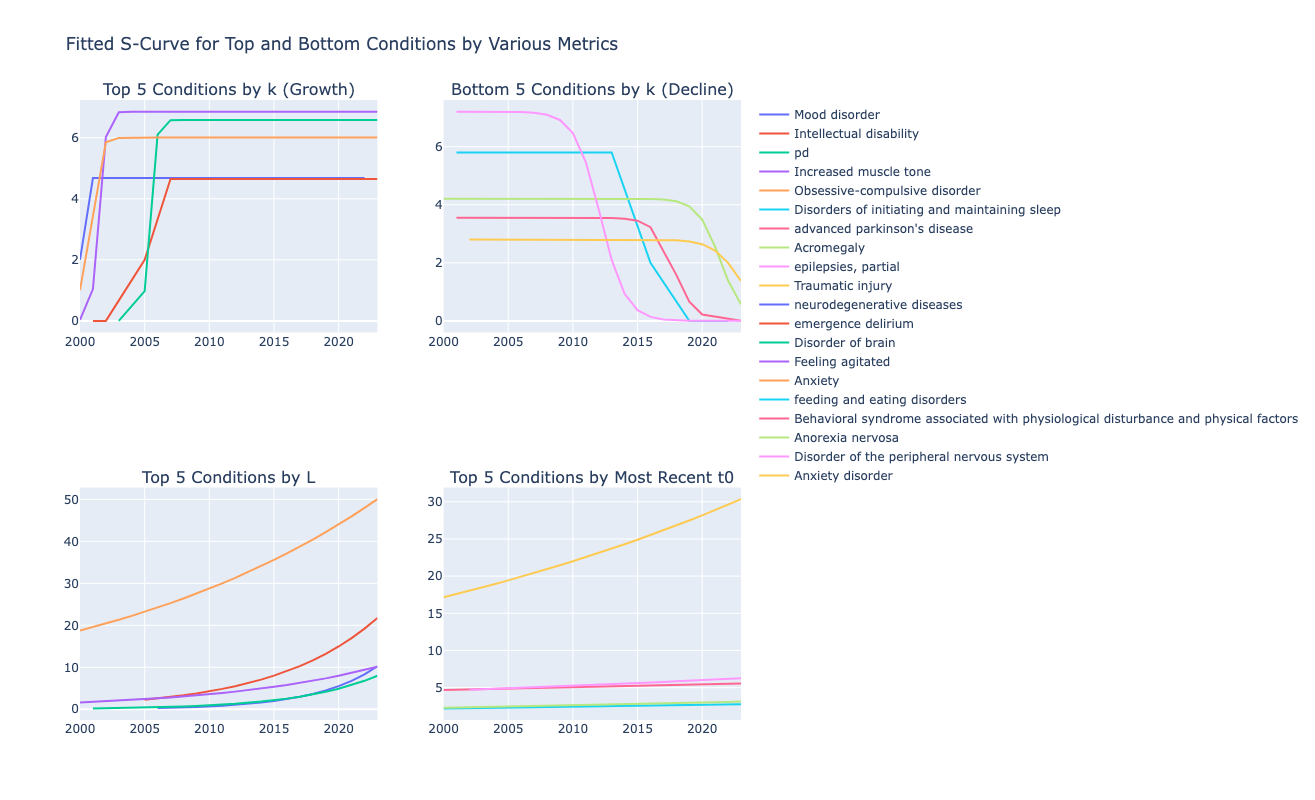

In [85]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=2, subplot_titles=(
    'Top 5 Conditions by k (Growth)',
    'Bottom 5 Conditions by k (Decline)',
    'Top 5 Conditions by L',
    'Top 5 Conditions by Most Recent t0'
))

# Plot for top k values
for index, row in top_k.iterrows():
    condition = row['Disease']
    condition_data = df[df['Neurological Condition'] == condition]
    years = condition_data['start_year'].values
    fitted_params = row[['L', 't0', 'k']].values
    trials = logistic_function(years, *fitted_params)
    fig.add_trace(go.Scatter(x=years, y=trials, mode='lines', name=condition), row=1, col=1)

# Plot for bottom k values
for index, row in bottom_k.iterrows():
    condition = row['Disease']
    condition_data = df[df['Neurological Condition'] == condition]
    years = condition_data['start_year'].values
    fitted_params = row[['L', 't0', 'k']].values
    trials = logistic_function(years, *fitted_params)
    fig.add_trace(go.Scatter(x=years, y=trials, mode='lines', name=condition), row=1, col=2)

# Plot for highest L values
for index, row in top_L.iterrows():
    condition = row['Disease']
    condition_data = df[df['Neurological Condition'] == condition]
    years = condition_data['start_year'].values
    fitted_params = row[['L', 't0', 'k']].values
    trials = logistic_function(years, *fitted_params)
    fig.add_trace(go.Scatter(x=years, y=trials, mode='lines', name=condition), row=2, col=1)

# Plot for most recent t0 values
for index, row in top_t0.iterrows():
    condition = row['Disease']
    condition_data = df[df['Neurological Condition'] == condition]
    years = condition_data['start_year'].values
    fitted_params = row[['L', 't0', 'k']].values
    trials = logistic_function(years, *fitted_params)
    fig.add_trace(go.Scatter(x=years, y=trials, mode='lines', name=condition), row=2, col=2)

# Update layout
fig.update_layout(height=800, width=1000, title_text='Fitted S-Curve for Top and Bottom Conditions by Various Metrics')
fig.show()

In [86]:
print("Top conditions based on interesting trends:")
print("Top k values:")
top_k


Top conditions based on interesting trends:
Top k values:


Disease         L          k           t0  \
70                   Mood disorder  4.681818  17.553242  2000.016671   
61         Intellectual disability  4.647059  13.229983  2005.021186   
141                             pd  6.583018   4.295793  2005.407691   
57           Increased muscle tone  6.856970   3.700926  2001.465012   
90   Obsessive-compulsive disorder  6.007460   2.616110  2000.611302   

     Total Trials  Spearmans coef  
70            105        0.071791  
61             83        0.352468  
141           121        0.151634  
57            152        0.199755  
90            133        0.030341

In [87]:
print("Bottom k values:")
bottom_k


Bottom k values:


Disease         L          k  \
36   Disorders of initiating and\nmaintaining sleep  5.800000 -11.270193   
130                    advanced parkinson's disease  3.551106  -1.256574   
0                                        Acromegaly  4.210445  -1.139240   
133                             epilepsies, partial  7.209548  -1.018295   
126                                Traumatic injury  2.799445  -0.950872   

              t0  Total Trials  Spearmans coef  
36   2015.943049            67       -0.586151  
130  2017.828647            57       -0.458526  
0    2021.379465            92       -0.262079  
133  2012.125800           103       -0.548317  
126  2022.959637            56       -0.101576

In [88]:
print("Top L values:")
top_L


Top L values:


Disease             L         k           t0  \
140  neurodegenerative diseases  1.089066e+06  0.206666  2078.999411   
132          emergence delirium  6.639451e+05  0.124891  2105.677319   
32            Disorder of brain  6.235391e+05  0.163554  2091.875554   
44             Feeling agitated  4.748351e+05  0.079984  2157.451477   
6                       Anxiety  4.651196e+05  0.042680  2237.077040   

     Total Trials  Spearmans coef  
140            57        0.705742  
132           169        0.912018  
32             52        0.834140  
44            116        0.524634  
6             768        0.716342

In [89]:
print("Most recent t0 values:")
top_t0

Most recent t0 values:


Disease             L  \
134                       feeding and eating disorders   2791.151061   
9    Behavioral syndrome associated with\nphysiolog...    782.814445   
5                                     Anorexia nervosa   4235.753804   
35          Disorder of the peripheral\nnervous system   7199.890542   
7                                     Anxiety disorder  95453.386353   

            k           t0  Total Trials  Spearmans coef  
134  0.009642  2740.476654            50       -0.026504  
9    0.007659  2667.987625           113        0.143905  
5    0.013615  2552.611068            52        0.195973  
35   0.013589  2541.491629           120        0.057065  
7    0.024810  2347.585705           556        0.469594

In [91]:
results_df[results_df['Disease']=='Schizophrenia']

Disease          L         k           t0  Total Trials  \
106  Schizophrenia  75.287786 -0.301595  2021.283827          1541   

     Spearmans coef  
106       -0.299195

### Linear Regression

In [92]:
from sklearn.linear_model import LinearRegression


In [93]:
def fit_and_evaluate_linear_regression(df, min_trials=5, use_normalized_trials_count=False):
    # Count the number of trials per condition
    condition_counts = df['Neurological Condition'].value_counts()
    print('Nr of conditions ', len(set(df['Neurological Condition'])))
    
    # Filter conditions with sufficient data
    sufficient_data_conditions = df[df['Neurological Condition'].isin(condition_counts[condition_counts >= min_trials].index)]
    print(f'Nr of conditions with more than {min_trials} trials', len(set(sufficient_data_conditions['Neurological Condition'])))

    # Group by condition and year, then count the trials
    grouped_data = sufficient_data_conditions.groupby(['Neurological Condition', 'start_year']).size().reset_index(name='unique_trials_count')
    
    # Normalize the number of trials for each condition
    grouped_data['Normalized Trials'] = grouped_data.groupby('Neurological Condition')['unique_trials_count'].transform(
        lambda x: 0 if x.max() == x.min() else (x - x.min()) / (x.max() - x.min())
    )

    results = []

    for condition in grouped_data['Neurological Condition'].unique():
        condition_data = grouped_data[grouped_data['Neurological Condition'] == condition]
        years = condition_data['start_year'].values.reshape(-1, 1)
        if use_normalized_trials_count:
            trials = condition_data['Normalized Trials'].values
        else:
            trials = condition_data['unique_trials_count'].values

        try:
            # Fit linear regression model
            model = LinearRegression()
            model.fit(years, trials)
            coef = model.coef_[0]
            intercept = model.intercept_
            total_trials = condition_data['unique_trials_count'].sum()
            results.append({'Disease': condition, 'Coefficient': coef, 'Intercept': intercept, 'Total Trials': total_trials})
        except Exception as e:
            print(f"Error fitting linear regression for {condition}: {e}")

    results_df = pd.DataFrame(results)
    return results_df, grouped_data

Coefficient (Slope): 1.3486956521739126
Intercept: -2680.9013043478253


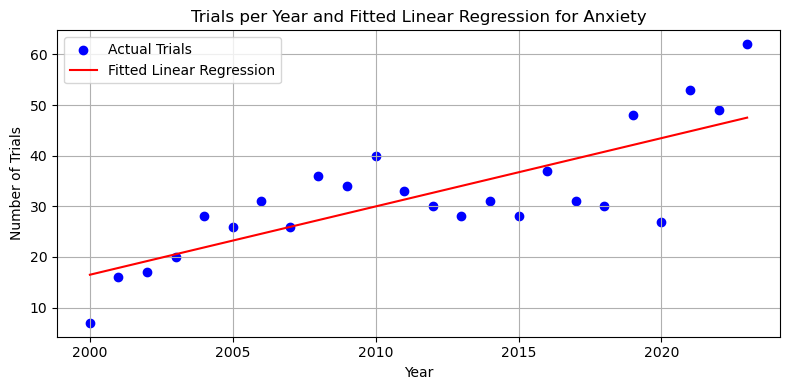

In [95]:
disease_name = 'Anxiety'
min_trials = 5  # Define minimum number of trials

# Filter for the specific disease
disease_data = df_unique_trials[df_unique_trials['Neurological Condition'] == disease_name]

# Check if there are enough data points
if len(disease_data) < min_trials:
    print(f"Not enough trials for {disease_name}. At least {min_trials} trials are required.")
else:
    # Group by year and count the trials
    yearly_data = disease_data.groupby('start_year').size().reset_index(name='trials_count')

    # Fit the linear regression model
    years = yearly_data['start_year'].values.reshape(-1, 1)
    trials = yearly_data['trials_count'].values

    model = LinearRegression()
    model.fit(years, trials)
    coef = model.coef_[0]
    intercept = model.intercept_

    print(f"Coefficient (Slope): {coef}")
    print(f"Intercept: {intercept}")

    # Generate fitted values
    fitted_trials = model.predict(years)

    # Plotting the results
    plt.figure(figsize=(8, 4))
    plt.scatter(years, trials, color='blue', label='Actual Trials')
    plt.plot(years, fitted_trials, color='red', label='Fitted Linear Regression')
    plt.title(f'Trials per Year and Fitted Linear Regression for {disease_name}')
    plt.xlabel('Year')
    plt.ylabel('Number of Trials')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(F"viz/trends/conditions_linear_regression_{disease_name}.png")
    plt.show()

In [96]:
df_unique_trials = aact_diseases[['nct_id', 'Neurological Condition','start_year']].drop_duplicates()

# Fit and evaluate logistic function for all conditions
results_df, unique_trials_per_year = fit_and_evaluate_linear_regression(df_unique_trials, min_trials=50, use_normalized_trials_count = False)
results_df

Nr of conditions  9704
Nr of conditions with more than 50 trials 142


Disease  Coefficient    Intercept  \
0                              Acromegaly    -0.086957   178.746377   
1                         Acute psychosis    -0.112648   229.691700   
2                     Aggressive behavior     0.033597   -65.162055   
3                                 Alcohol    -0.031543    66.093102   
4                     Alzheimer's disease     1.803913 -3577.696087   
..                                    ...          ...          ...   
137  mild-to-moderate alzheimer's disease    -0.049123   101.515789   
138                    motor fluctuations     0.080799  -159.670449   
139                                    ms     0.235178  -467.177866   
140            neurodegenerative diseases     0.393964  -790.225938   
141                                    pd     0.126360  -248.368713   

     Total Trials  
0              92  
1              70  
2              56  
3              53  
4            1221  
..            ...  
137            50  
138            56  
139           138  
140            57  
141           121  

[142 rows x 4 columns]

<Figure size 1000x800 with 0 Axes>

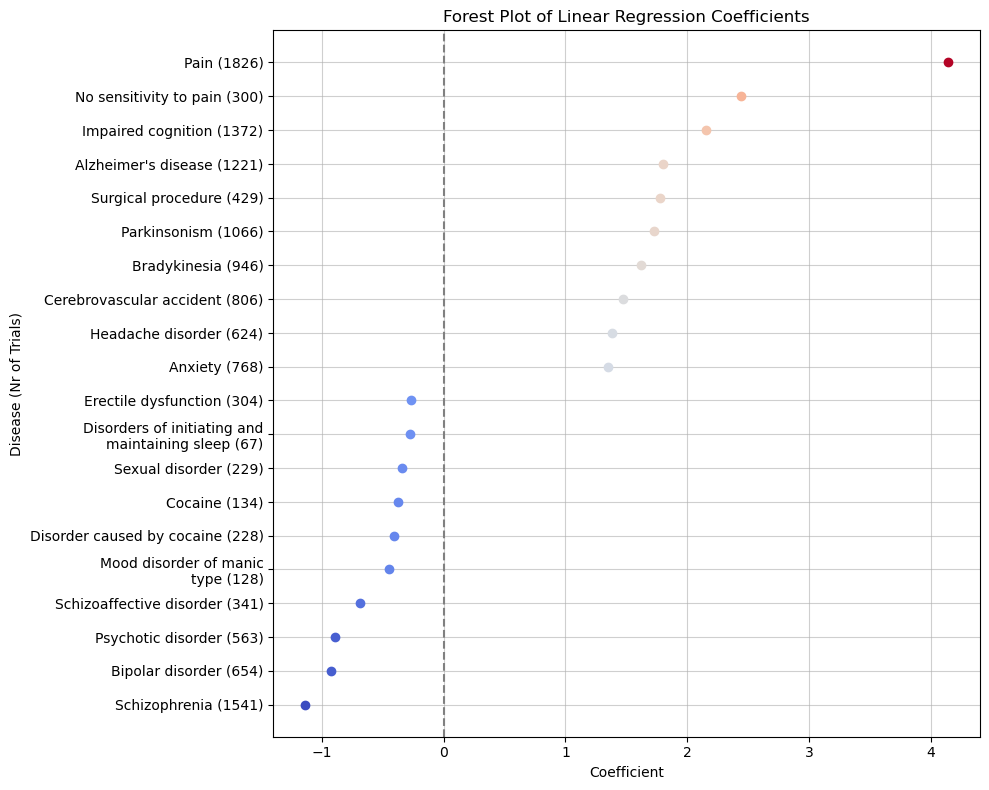

In [97]:
# Sort by Coefficient to find the top 10 highest and lowest
sorted_df = results_df.sort_values(by='Coefficient')

# Select the top 10 lowest and top 10 highest coefficients
top_10_lowest = sorted_df.head(10)
top_10_highest = sorted_df.tail(10)

# Combine the two sets
combined_df = pd.concat([top_10_lowest, top_10_highest])

# Add the number of trials to the disease names
combined_df['Disease (Nr of Trials)'] = combined_df.apply(
    lambda row: f"{row['Disease']} ({row['Total Trials']})", axis=1
)

# Create the forest plot
plt.figure(figsize=(10, 8))
# Normalize the Coefficient values for color mapping
norm = plt.Normalize(combined_df['Coefficient'].min(), combined_df['Coefficient'].max())
colors = plt.cm.coolwarm(norm(combined_df['Coefficient']))

# Create the forest plot
plt.figure(figsize=(10, 8))
for i, (coef, disease) in enumerate(zip(combined_df['Coefficient'], combined_df['Disease (Nr of Trials)'])):
    plt.errorbar(coef, i, xerr=0, fmt='o', color=colors[i])

#plt.errorbar(combined_df['Coefficient'], combined_df['Disease (Nr of Trials)'], fmt='o', xerr=0, color='blue')
plt.axvline(x=0, color='grey', linestyle='--')
plt.yticks(range(len(combined_df)), combined_df['Disease (Nr of Trials)'])

plt.title('Forest Plot of Linear Regression Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Disease (Nr of Trials)')
plt.grid(linestyle='-', alpha=0.6, zorder=0)
plt.tight_layout()
plt.savefig("viz/trends/conditions_linear_regression.png")
plt.show()

### Percentage growth

In [98]:
from datetime import datetime

In [100]:
df = aact_diseases.copy()

# Convert start_year to int
df['start_year'] = df['start_year'].astype(int)

# Filter data for the years 2013, 2018, 2020, and 2023
df_filtered = df[df['start_year'].isin([2013, 2018, 2020, 2023])]

# Remove duplicate trials based on nct_id and Neurological Condition
df_unique_trials = df_filtered.drop_duplicates(subset=['nct_id', 'Neurological Condition'])

# Filter conditions with sufficient data
condition_counts = df_unique_trials['Neurological Condition'].value_counts()
df_unique_trials = df_unique_trials[df_unique_trials['Neurological Condition'].isin(condition_counts[condition_counts >= 10].index)]

# Group by Neurological Condition and start_year, and count unique trials
unique_trials_per_year = df_unique_trials.groupby(['Neurological Condition', 'start_year']).size().reset_index(name='unique_trials_count')

# Pivot the data for easier comparison
pivot_df = unique_trials_per_year.pivot(index='Neurological Condition', columns='start_year', values='unique_trials_count').fillna(0)

# Flatten the DataFrame so that 'Neurological Condition' and 'start_year' are on the same level
pivot_df.columns = [str(col) for col in pivot_df.columns]
pivot_df.reset_index(inplace=True)

def calculate_growth(row, start_year, end_year):
    start_trials = row[str(start_year)]
    end_trials = row[str(end_year)]
    if start_trials == 0:
        return 100 if end_trials > 0 else 0
    return ((end_trials - start_trials) / start_trials) * 100

# Calculate growth rates for different time spans
pivot_df['3_year_growth'] = pivot_df.apply(lambda row: calculate_growth(row, 2020, 2023), axis=1)
pivot_df['5_year_growth'] = pivot_df.apply(lambda row: calculate_growth(row, 2018, 2023), axis=1)
pivot_df['10_year_growth'] = pivot_df.apply(lambda row: calculate_growth(row, 2013, 2023), axis=1)

# Fill NaN values with 0
pivot_df.fillna(0, inplace=True)

# Sorting the DataFrame by one of the growth metrics for review
sorted_pivot_df = pivot_df.sort_values(by='10_year_growth', ascending=False)

In [101]:
sorted_pivot_df.head(10)

Neurological Condition  2013  2018  2020  2023  3_year_growth  \
87            No sensitivity to pain   4.0  14.0  44.0  37.0     -15.909091   
20   Degenerative disorder of muscle   4.0  19.0   8.0  33.0     312.500000   
72                    Muscle atrophy   1.0   1.0   2.0   8.0     300.000000   
118                  Synucleinopathy   1.0   5.0   8.0   8.0       0.000000   
33                         Dyssomnia   2.0  10.0  11.0  14.0      27.272727   
103                       Sarcopenia   6.0  18.0  12.0  37.0     208.333333   
26        Disorder caused by alcohol   1.0   2.0   2.0   6.0     200.000000   
76                          Myositis   2.0   6.0   5.0  11.0     120.000000   
98           Postoperative procedure   1.0   3.0   9.0   5.0     -44.444444   
40           Frontotemporal dementia   1.0   4.0   3.0   4.0      33.333333   

     5_year_growth  10_year_growth  
87      164.285714      825.000000  
20       73.684211      725.000000  
72      700.000000      700.000000  
118      60.000000      700.000000  
33       40.000000      600.000000  
103     105.555556      516.666667  
26      200.000000      500.000000  
76       83.333333      450.000000  
98       66.666667      400.000000  
40        0.000000      300.000000

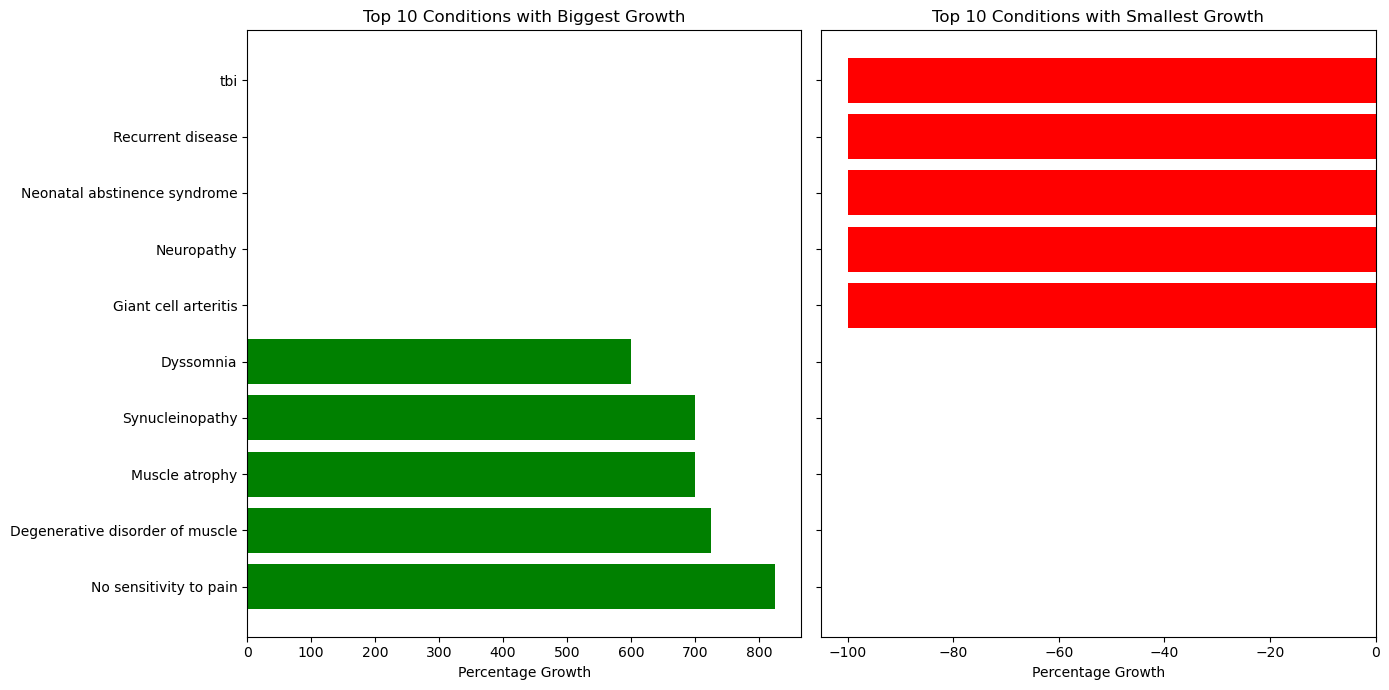

In [103]:
# Top 10 conditions with biggest growth
top_10_biggest_growth = sorted_pivot_df.head(5)

# Top 10 conditions with smallest growth
top_10_smallest_growth = sorted_pivot_df.tail(5)

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), sharey=True)

# Plot for biggest growth
axes[0].barh(top_10_biggest_growth['Neurological Condition'], top_10_biggest_growth['10_year_growth'], color='green')
axes[0].set_title('Top 10 Conditions with Biggest Growth')
axes[0].set_xlabel('Percentage Growth')
axes[0].invert_yaxis()  # highest values at the top

# Plot for smallest growth
axes[1].barh(top_10_smallest_growth['Neurological Condition'], top_10_smallest_growth['10_year_growth'], color='red')
axes[1].set_title('Top 10 Conditions with Smallest Growth')
axes[1].set_xlabel('Percentage Growth')
axes[1].invert_yaxis()  # lowest values at the top

plt.tight_layout()
plt.show()

In [104]:
sorted_pivot_df

Neurological Condition  2013  2018  2020  2023  3_year_growth  \
87            No sensitivity to pain   4.0  14.0  44.0  37.0     -15.909091   
20   Degenerative disorder of muscle   4.0  19.0   8.0  33.0     312.500000   
72                    Muscle atrophy   1.0   1.0   2.0   8.0     300.000000   
118                  Synucleinopathy   1.0   5.0   8.0   8.0       0.000000   
33                         Dyssomnia   2.0  10.0  11.0  14.0      27.272727   
..                               ...   ...   ...   ...   ...            ...   
41              Giant cell arteritis   2.0   4.0   4.0   0.0    -100.000000   
84                        Neuropathy   3.0   4.0   4.0   0.0    -100.000000   
77      Neonatal abstinence syndrome   1.0   4.0   5.0   0.0    -100.000000   
101                Recurrent disease   1.0   6.0   3.0   0.0    -100.000000   
141                              tbi   3.0   1.0   6.0   0.0    -100.000000   

     5_year_growth  10_year_growth  
87      164.285714           825.0  
20       73.684211           725.0  
72      700.000000           700.0  
118      60.000000           700.0  
33       40.000000           600.0  
..             ...             ...  
41     -100.000000          -100.0  
84     -100.000000          -100.0  
77     -100.000000          -100.0  
101    -100.000000          -100.0  
141    -100.000000          -100.0  

[142 rows x 8 columns]

# Interventions

In [127]:
import textwrap


In [128]:
viz_path_interventions = Path("viz/interventions/")

In [129]:
aact_disease_intervention = reference_data[['nct_id', condition_col_name, 'Disease Class', drug_col_name, 'intervention_type', 'phase', 'overall_status', 'start_year']]

In [130]:
#filtered_df = aact_disease_intervention[(aact_disease_intervention['intervention_type'] == 'Drug') | (aact_disease_intervention['intervention_type'] == 'Biological')]
#filtered_df = aact_disease_intervention[(aact_disease_intervention['intervention_name'] != 'Saline') & (aact_disease_intervention['intervention_type'] != 'Normal saline')]
#filtered_df.head(10)

In [131]:
aact_disease_intervention[drug_col_name].isnull().sum()

0

In [132]:
aact_disease_intervention.dropna(subset=[drug_col_name], inplace=True)
aact_disease_intervention.drop(aact_disease_intervention[aact_disease_intervention[drug_col_name] == ''].index, inplace=True)

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_45581/1930621683.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_45581/1930621683.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [133]:
# Keeping only unique nct_id, phase pairs
unique_pairs = aact_disease_intervention[['nct_id', drug_col_name]].drop_duplicates()

# Counting the number of nct_ids per phase type
drug_counts = unique_pairs[drug_col_name].value_counts()
drug_counts

Drug Intervention
Risperidone                                                              323
Levodopa                                                                 288
Ketamine                                                                 261
Olanzapine                                                               255
Aripiprazole                                                             232
                                                                        ... 
levulan (5-aminolevulinic acid) photodynamic\ntherapy - dose level\n3      1
part 1 levulan injection                                                   1
part 1 levulan surface\napplication                                        1
part 1 levulan surface\napplication twice                                  1
dmb-i (dimebon)                                                            1
Name: count, Length: 16377, dtype: int64

In [134]:
drug_counts[:30]

Drug Intervention
Risperidone                    323
Levodopa                       288
Ketamine                       261
Olanzapine                     255
Aripiprazole                   232
Dexmedetomidine                228
Quetiapine                     212
Anti-psychotic agent           200
Donepezil                      168
Nicotine                       163
Clostridium botulinum toxin    156
Botulinum toxin type A         151
Escitalopram                   146
Propofol                       146
Lidocaine                      144
Memantine                      139
Pregabalin                     139
Levetiracetam                  129
Cannabidiol                    126
Valproic acid                  126
Oxytocin                       125
Lithium                        124
Melatonin                      123
Aspirin                        123
Topiramate                     122
Varenicline                    121
N-3 fatty acid                 120
Bupropion                      119
La

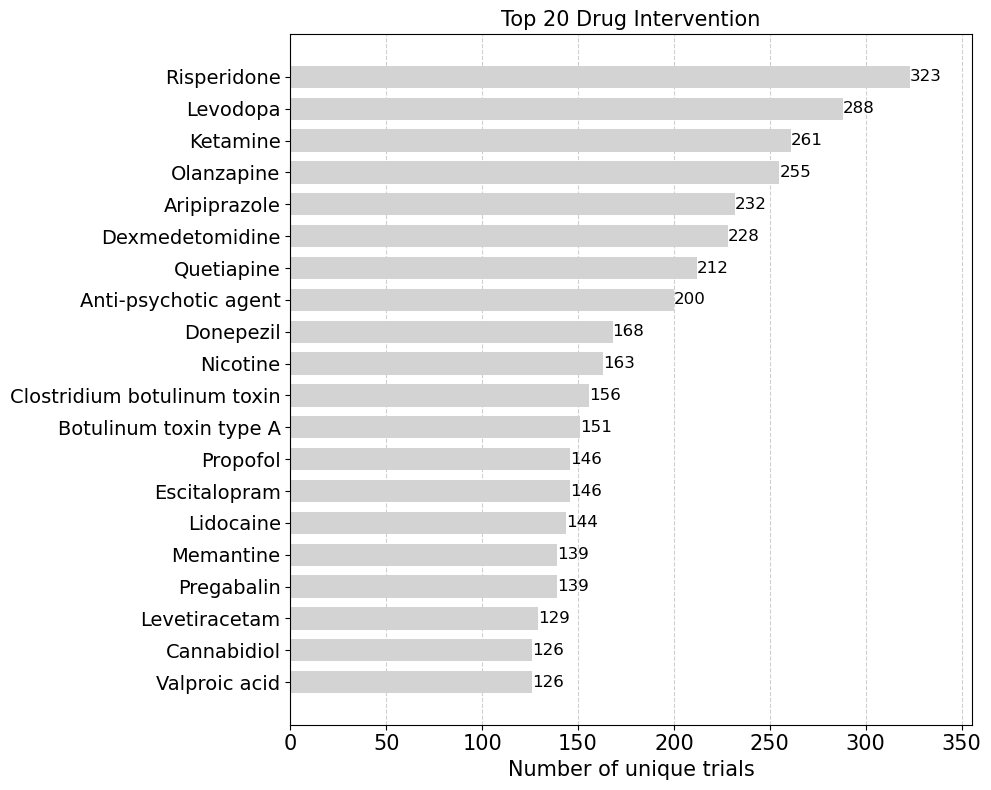

In [135]:
plot_entity_frequency(aact_disease_intervention, drug_col_name, 'interventions', annotations_type, viz_path_interventions, top_n=20)


In [136]:
# Aggregate trials by disease and phase, counting unique nct_ids
intervention_phase_counts = aact_disease_intervention.groupby([drug_col_name, 'phase'])['nct_id'].nunique().reset_index()

#intervention_phase_counts_filtered = intervention_phase_counts[intervention_phase_counts['phase'] != 'Not Applicable']

# Pivot the filtered data to have interventions as rows and phases as columns
pivot_intervention_df_filtered = intervention_phase_counts.pivot(index=drug_col_name, columns='phase', values='nct_id').fillna(0)

# Calculate total trials per intervention again without 'Not Applicable' phase
pivot_intervention_df_filtered['Total Trials'] = pivot_intervention_df_filtered.sum(axis=1)
top_interventions_filtered = pivot_intervention_df_filtered.sort_values('Total Trials', ascending=False).head(20)
top_interventions_filtered

phase                        Early Phase 1  Not Applicable  Phase 1  \
Drug Intervention                                                     
Risperidone                            1.0            36.0     26.0   
Levodopa                               2.0            23.0     47.0   
Ketamine                              14.0            51.0     36.0   
Olanzapine                             1.0            34.0      8.0   
Aripiprazole                           1.0            23.0     19.0   
Dexmedetomidine                        7.0            67.0      7.0   
Quetiapine                             1.0            20.0      7.0   
Anti-psychotic agent                   1.0            44.0     11.0   
Donepezil                              2.0            10.0     34.0   
Nicotine                              12.0            63.0     29.0   
Clostridium botulinum toxin            4.0            47.0     12.0   
Botulinum toxin type A                 5.0            26.0      4.0   
Propofol                               5.0            62.0      2.0   
Escitalopram                           2.0            23.0      9.0   
Lidocaine                              5.0            54.0     11.0   
Memantine                              1.0            14.0      7.0   
Pregabalin                             2.0            12.0      2.0   
Levetiracetam                          0.0            17.0      4.0   
Cannabidiol                            5.0            11.0     13.0   
Valproic acid                          1.0             8.0     12.0   

phase                        Phase 1/Phase 2  Phase 2  Phase 2/Phase 3  \
Drug Intervention                                                        
Risperidone                              8.0     39.0              6.0   
Levodopa                                12.0     76.0             11.0   
Ketamine                                11.0     58.0             16.0   
Olanzapine                               5.0     31.0              2.0   
Aripiprazole                             3.0     25.0              4.0   
Dexmedetomidine                          7.0     17.0              8.0   
Quetiapine                               3.0     16.0              4.0   
Anti-psychotic agent                     5.0     22.0              6.0   
Donepezil                                2.0     45.0              0.0   
Nicotine                                 6.0     24.0              2.0   
Clostridium botulinum toxin              8.0     20.0              6.0   
Botulinum toxin type A                   6.0     33.0              5.0   
Propofol                                 1.0      3.0              2.0   
Escitalopram                             0.0     12.0              8.0   
Lidocaine                                2.0     19.0              4.0   
Memantine                                4.0     31.0              7.0   
Pregabalin                               2.0     15.0              4.0   
Levetiracetam                            6.0     30.0              3.0   
Cannabidiol                              8.0     48.0              8.0   
Valproic acid                            4.0     24.0              5.0   

phase                        Phase 3  Phase 4  Total Trials  
Drug Intervention                                            
Risperidone                     79.0    128.0         323.0  
Levodopa                        69.0     48.0         288.0  
Ketamine                        18.0     57.0         261.0  
Olanzapine                      70.0    104.0         255.0  
Aripiprazole                    64.0     93.0         232.0  
Dexmedetomidine                 23.0     92.0         228.0  
Quetiapine                      73.0     88.0         212.0  
Anti-psychotic agent            38.0     73.0         200.0  
Donepezil                       30.0     45.0         168.0  
Nicotine                         5.0     22.0         163.0  
Clostridium botulinum toxin     30.0     29.0         156.0  
Bo

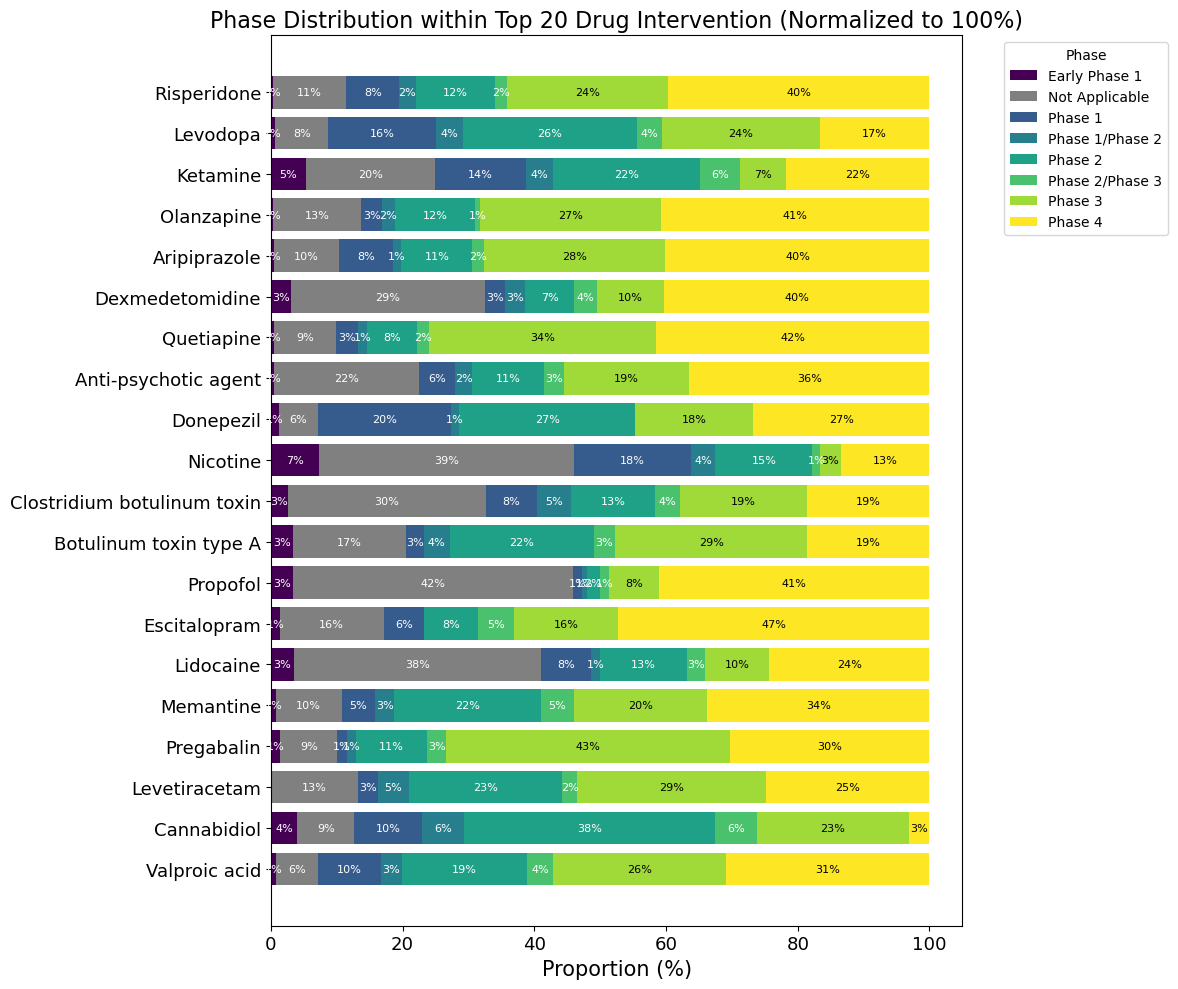

In [137]:
plot_phase_distribution(aact_disease_intervention, drug_col_name, 'interventions', 'phase', 'nct_id', annotations_type, viz_path_interventions, top_n=20)


In [138]:
aact_disease_intervention

nct_id       Neurological Condition           Disease Class  \
382     NCT00000307   Disorder caused by alcohol       Diseases Category   
382     NCT00000307   Disorder caused by cocaine       Diseases Category   
382     NCT00000307  alcoholic cocaine dependent       Diseases Category   
383     NCT00000307   Disorder caused by alcohol       Diseases Category   
383     NCT00000307   Disorder caused by cocaine       Diseases Category   
...             ...                          ...                     ...   
262609  NCT06293586          oculocardiac reflex  Cranial Nerve Diseases   
262610  NCT06293586                   Strabismus  Cranial Nerve Diseases   
262610  NCT06293586           Surgical procedure  Cranial Nerve Diseases   
262610  NCT06293586                           oc  Cranial Nerve Diseases   
262610  NCT06293586          oculocardiac reflex  Cranial Nerve Diseases   

       Drug Intervention intervention_type           phase overall_status  \
382           Naltrexone              Drug         Phase 2      Completed   
382           Naltrexone              Drug         Phase 2      Completed   
382           Naltrexone              Drug         Phase 2      Completed   
383           Naltrexone              Drug         Phase 2      Completed   
383           Naltrexone              Drug         Phase 2      Completed   
...                  ...               ...             ...            ...   
262609       Paracetamol         Procedure  Not Applicable     Recruiting   
262610       Paracetamol              Drug  Not Applicable     Recruiting   
262610       Paracetamol              Drug  Not Applicable     Recruiting   
262610       Paracetamol              Drug  Not Applicable     Recruiting   
262610       Paracetamol              Drug  Not Applicable     Recruiting   

        start_year  
382         2003.0  
382         2003.0  
382         2003.0  
383         2003.0  
383         2003.0  
...            ...  
262609      2023.0  
262610      2023.0  
262610      2023.0  
262610      2023.0  
262610      2023.0  

[2785417 rows x 8 columns]

yearly totals
start_year
2000.0     135
2001.0     231
2002.0     310
2003.0     512
2004.0     652
2005.0     714
2006.0     815
2007.0     803
2008.0     863
2009.0     893
2010.0     852
2011.0     816
2012.0     802
2013.0     761
2014.0     868
2015.0     894
2016.0     850
2017.0     883
2018.0     883
2019.0     947
2020.0     887
2021.0    1066
2022.0     996
2023.0     942
Name: nct_id, dtype: int64


/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_45581/1695848084.py:71: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



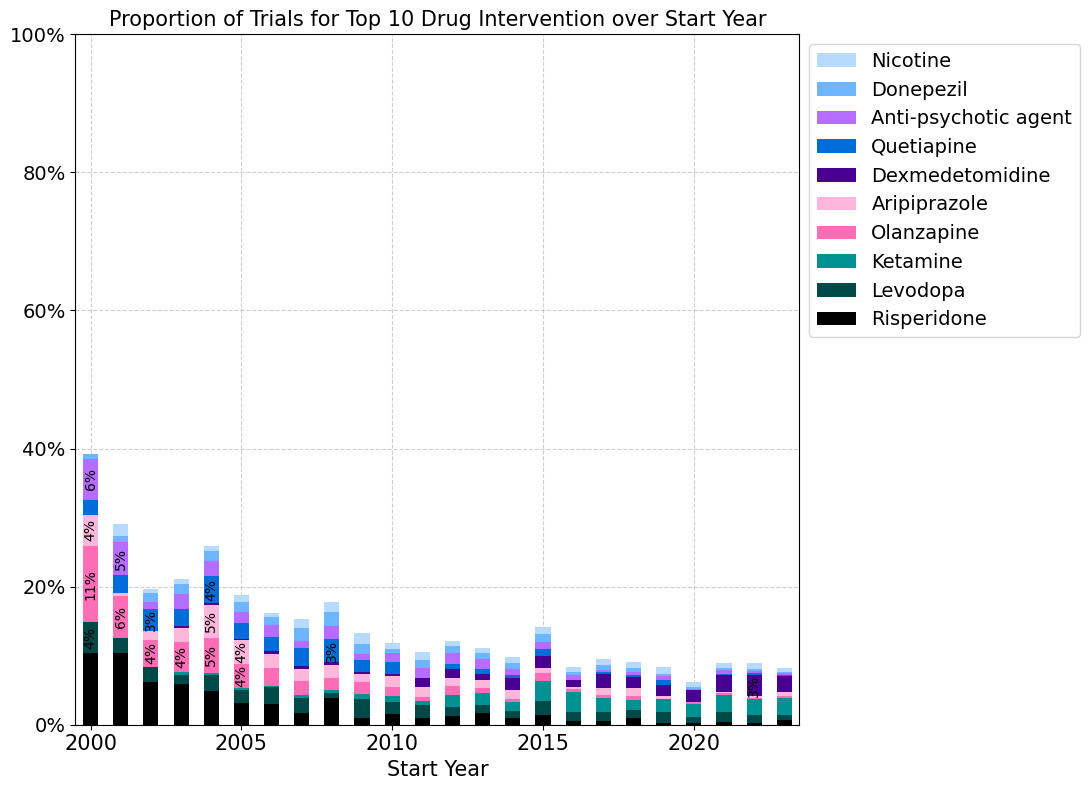

In [139]:
plot_stacked_over_time_global_totals(aact_disease_intervention, drug_col_name, 'interventions', 'start_year', 'nct_id', annotations_type, viz_path_interventions, top_n=10, custom_palette = custom_colors)


/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_45581/1530534109.py:63: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



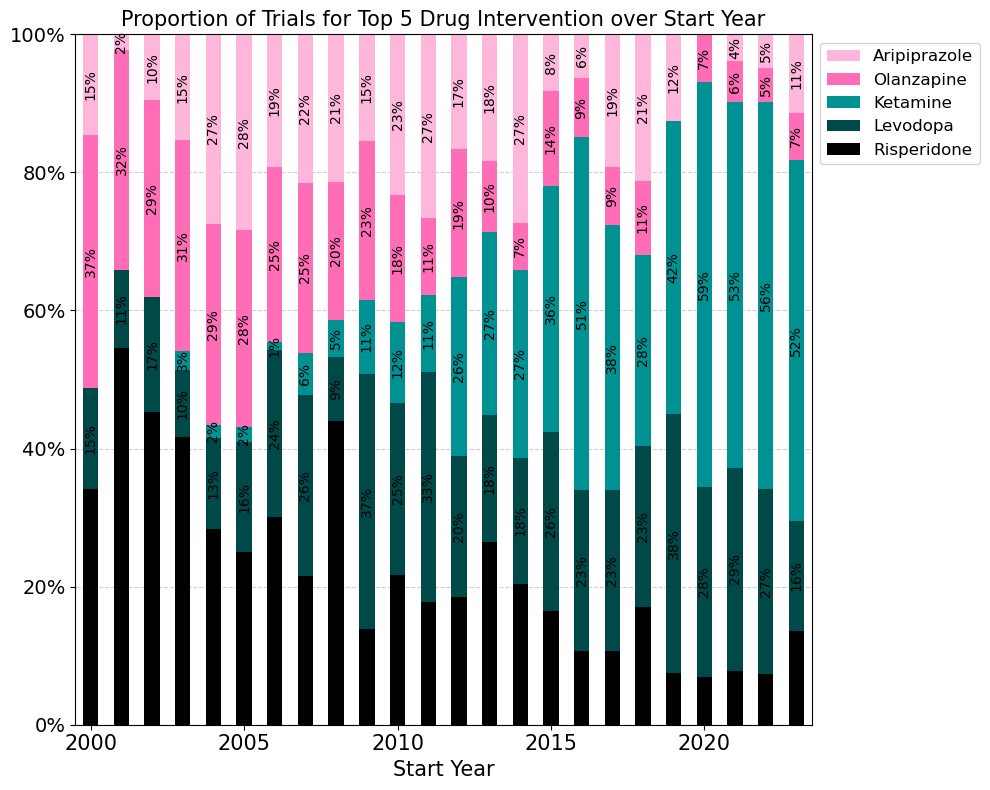

In [140]:
plot_stacked_over_time(aact_disease_intervention, drug_col_name, 'interventions', 'start_year', 'nct_id', annotations_type, viz_path_interventions, top_n=5, custom_palette = custom_colors)


Drug Intervention
Risperidone     323
Levodopa        288
Ketamine        261
Olanzapine      255
Aripiprazole    232
Name: count, dtype: int64


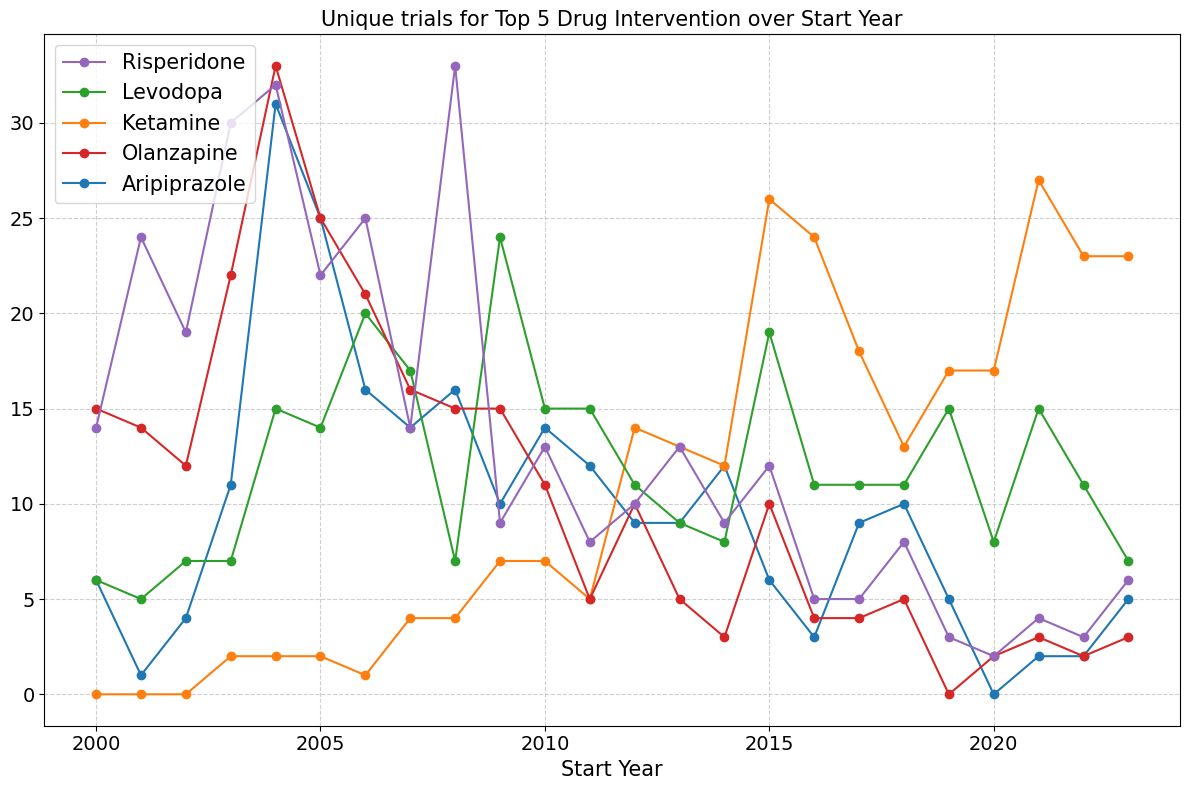

In [141]:
plot_distribution_over_time(aact_disease_intervention, drug_col_name, 'interventions', 'start_year', 'nct_id', annotations_type, viz_path_interventions, top_n=5)


## Intervention/ Disease

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_45581/4225371427.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



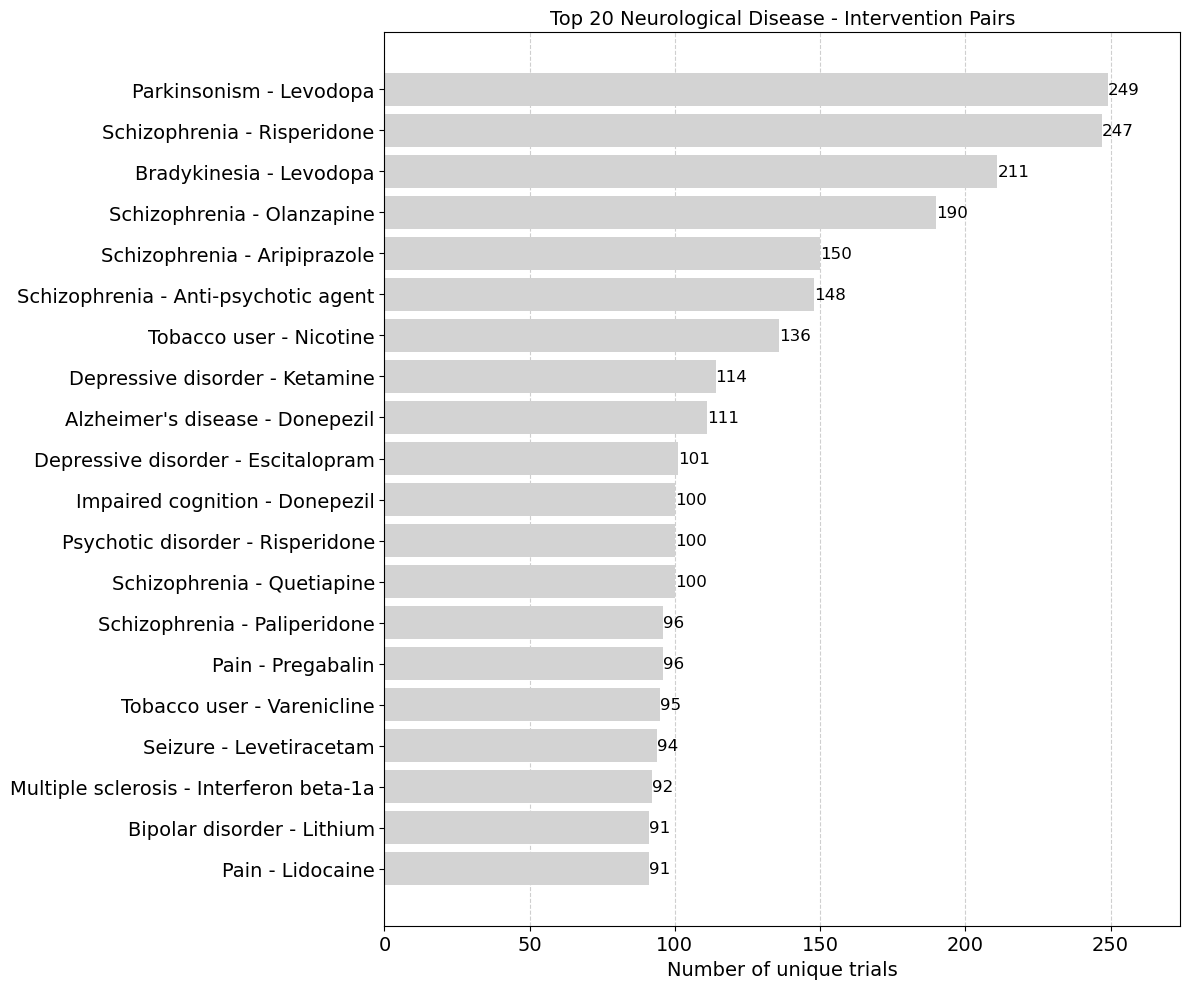

In [123]:
filtered_df = aact_disease_intervention.copy()

# Normalize drug_col_name to start with a capital letter
filtered_df[drug_col_name] = filtered_df[drug_col_name].str.capitalize()

# Drop duplicates based on 'nct_id' to ensure uniqueness
filtered_df_unique = filtered_df.drop_duplicates(subset=['nct_id', condition_col_name, drug_col_name])

# Create pairs of unique 'nct_id'
filtered_df_unique['disease_intervention_pair'] = filtered_df_unique[condition_col_name] + ' - ' + filtered_df_unique[drug_col_name]

# Count the frequency of each unique pair
pair_counts_unique = filtered_df_unique['disease_intervention_pair'].value_counts()

# Select the top 20 most frequent pairs
top_20_pairs_unique = pair_counts_unique.head(20).sort_values(ascending=True)  # Sort ascending for plot layout

# Plot with specified formatting
plt.figure(figsize=(12, 10))
bars = plt.barh(top_20_pairs_unique.index, top_20_pairs_unique, color='lightgrey', zorder=2)

# Add labels to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width}', va='center', fontsize=12)

plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6, zorder=1)
plt.xlabel('Number of unique trials', fontsize=14)
plt.title(f'Top 20 Neurological Disease - Intervention Pairs', fontsize=14)
plt.tight_layout()
plt.xlim(0, max(pair_counts_unique) + max(pair_counts_unique)/10)  # Adjusted to max count for relevancy

# Save the plot to a local folder
plt.savefig(f'viz/disease_intervention_pair_frequency_{annotations_type}.pdf')

plt.show()


In [1865]:
filtered_df_unique[filtered_df_unique['Neurological Condition']=="Alzheimer's disease"]

nct_id Neurological Condition  \
3332    NCT00007189    Alzheimer's disease   
3332    NCT00007189    Alzheimer's disease   
3332    NCT00007189    Alzheimer's disease   
3332    NCT00007189    Alzheimer's disease   
3381    NCT00009191    Alzheimer's disease   
...             ...                    ...   
261153  NCT06194552    Alzheimer's disease   
261376  NCT06217146    Alzheimer's disease   
261706  NCT06234436    Alzheimer's disease   
262587  NCT06292351    Alzheimer's disease   
262587  NCT06292351    Alzheimer's disease   

                             Disease Class  \
3332            Neurodegenerative Diseases   
3332            Neurodegenerative Diseases   
3332            Neurodegenerative Diseases   
3332            Neurodegenerative Diseases   
3381            Neurodegenerative Diseases   
...                                    ...   
261153          Neurodegenerative Diseases   
261376  Psychiatry and Psychology Category   
261706          Neurodegenerative Diseases   
262587          Neurodegenerative Diseases   
262587          Neurodegenerative Diseases   

                                     Drug Intervention intervention_type  \
3332                                         Celecoxib              Drug   
3332                                          Naproxen              Drug   
3332                                   Naproxen sodium              Drug   
3332             Non-steroidal anti-inflammatory agent              Drug   
3381                                        Sertraline              Drug   
...                                                ...               ...   
261153                        Methylnaltrexone bromide              Drug   
261376                                        Cannabis              Drug   
261706                              Plasma substitutes        Biological   
262587                                         Dimetan              Drug   
262587  N-methyl-1-(1,3-benzodioxol-5-yl)-2-butanamine              Drug   

                  phase           overall_status  start_year  \
3332            Phase 3                Completed      2001.0   
3332            Phase 3                Completed      2001.0   
3332            Phase 3                Completed      2001.0   
3332            Phase 3                Completed      2001.0   
3381            Phase 4                Completed      2005.0   
...                 ...                      ...         ...   
261153          Phase 1                Completed      2022.0   
261376   Not Applicable               Recruiting      2022.0   
261706    Early Phase 1  Enrolling by invitation      2023.0   
262587  Phase 2/Phase 3               Recruiting      2023.0   
262587  Phase 2/Phase 3               Recruiting      2023.0   

                                disease_intervention_pair  
3332                      Alzheimer's disease - Celecoxib  
3332                       Alzheimer's disease - Naproxen  
3332                Alzheimer's disease - Naproxen sodium  
3332    Alzheimer's disease - Non-steroidal anti-infla...  
3381                     Alzheimer's disease - Sertraline  
...                                                   ...  
261153     Alzheimer's disease - Methylnaltrexone bromide  
261376                     Alzheimer's disease - Cannabis  
261706           Alzheimer's disease - Plasma substitutes  
262587                      Alzheimer's disease - Dimetan  
262587  Alzheimer's disease - N-methyl-1-(1,3-benzodio...  

[2529 rows x 9 columns]

In [1866]:
filtered_df_unique[filtered_df_unique['nct_id']=="NCT01760005"]

nct_id Neurological Condition  \
128084  NCT01760005    Alzheimer's disease   
128084  NCT01760005               Dementia   
128084  NCT01760005       Familial disease   
128084  NCT01760005    Alzheimer's disease   
128084  NCT01760005               Dementia   
128084  NCT01760005       Familial disease   
128084  NCT01760005    Alzheimer's disease   
128084  NCT01760005               Dementia   
128084  NCT01760005       Familial disease   
128084  NCT01760005    Alzheimer's disease   
128084  NCT01760005               Dementia   
128084  NCT01760005       Familial disease   

                                            Disease Class  \
128084  Diseases of the nervous system|Central Nervous...   
128084  Diseases of the nervous system|Central Nervous...   
128084  Diseases of the nervous system|Central Nervous...   
128084  Diseases of the nervous system|Central Nervous...   
128084  Diseases of the nervous system|Central Nervous...   
128084  Diseases of the nervous system|Central Nervous...   
128084  Diseases of the nervous system|Central Nervous...   
128084  Diseases of the nervous system|Central Nervous...   
128084  Diseases of the nervous system|Central Nervous...   
128084  Diseases of the nervous system|Central Nervous...   
128084  Diseases of the nervous system|Central Nervous...   
128084  Diseases of the nervous system|Central Nervous...   

           Drug Intervention intervention_type            phase  \
128084         Crizanlizumab              Drug  Phase 2/Phase 3   
128084         Crizanlizumab              Drug  Phase 2/Phase 3   
128084         Crizanlizumab              Drug  Phase 2/Phase 3   
128084      Gliadin antibody              Drug  Phase 2/Phase 3   
128084      Gliadin antibody              Drug  Phase 2/Phase 3   
128084      Gliadin antibody              Drug  Phase 2/Phase 3   
128084  Monosodium glutamate              Drug  Phase 2/Phase 3   
128084  Monosodium glutamate              Drug  Phase 2/Phase 3   
128084  Monosodium glutamate              Drug  Phase 2/Phase 3   
128084           Sacituzumab              Drug  Phase 2/Phase 3   
128084           Sacituzumab              Drug  Phase 2/Phase 3   
128084           Sacituzumab              Drug  Phase 2/Phase 3   

       overall_status  start_year                   disease_intervention_pair  
128084     Recruiting      2012.0         Alzheimer's disease - Crizanlizumab  
128084     Recruiting      2012.0                    Dementia - Crizanlizumab  
128084     Recruiting      2012.0            Familial disease - Crizanlizumab  
128084     Recruiting      2012.0      Alzheimer's disease - Gliadin antibody  
128084     Recruiting      2012.0                 Dementia - Gliadin antibody  
128084     Recruiting      2012.0         Familial disease - Gliadin antibody  
128084     Recruiting      2012.0  Alzheimer's disease - Monosodium glutamate  
128084     Recruiting      2012.0             Dementia - Monosodium glutamate  
128084     Recruiting      2012.0     Familial disease - Monosodium glutamate  
128084     Recruiting      2012.0           Alzheimer's disease - Sacituzumab  
128084     Recruiting      2012.0                      Dementia - Sacituzumab  
128084     Recruiting      2012.0              Familial disease - Sacituzumab

In [1628]:
disease_intervenion_pairs = filtered_df_unique[['nct_id', 'disease_intervention_pair']].drop_duplicates()

In [1629]:
disease_intervenion_pairs.to_csv(f"./analysis/disease_intervenion_pairs_{annotations_type}.csv")


In [1630]:
aact_disease_intervention_with_entity_tags = reference_data_with_entity_tags[['nct_id', condition_col_name, 'Disease Class', drug_col_name, 'intervention_type', 'phase', 'overall_status', 'start_year']]
filtered_df = aact_disease_intervention_with_entity_tags.copy()

In [1870]:
filtered_df_unique.groupby('Neurological Condition')['Drug Intervention'].nunique().sort_values(ascending=False)

Neurological Condition
Depressive disorder                            1127
Neoplastic disease                             1106
Alzheimer's disease                            1076
Infectious disease                             1009
Schizophrenia                                   920
                                               ... 
Nonsense mutations                                1
Bp1                                               1
Bp-nos                                            1
Norepinephrine serotonin reuptake inhibitor       1
&                                                 1
Name: Drug Intervention, Length: 2811, dtype: int64

In [1876]:
depressive_disorder_interventions = filtered_df_unique[filtered_df_unique['Neurological Condition'] == 'Depressive disorder']['Drug Intervention'].unique()
depressive_disorder_interventions

array(['Naltrexone', 'Sertraline', 'Cisplatin', ..., 'Anti jo-1 antibody',
       'Antigen of inactivated whole\njapanese encephalitis virus adsorbed',
       'Js1-1-01 high-dose group'], dtype=object)

In [1877]:
depressive_disorder_interventions = filtered_df_unique[filtered_df_unique['Neurological Condition'] == 'Neoplastic disease']['Drug Intervention'].unique()
depressive_disorder_interventions

array(['Temozolomide', 'Cisplatin', 'Fluoxetine', ...,
       'Immune suppressor gene', 'Loperamide hydrochloride',
       'Loperamide oxide'], dtype=object)

In [1927]:
depressive_disorder_interventions = filtered_df_unique[filtered_df_unique['Neurological Condition'] == 'Schizophrenia']['Drug Intervention'].unique()
depressive_disorder_interventions[:100]

array(['Amino acid', 'Glycine', 'Anti-psychotic agent',
       'Atypical antipsychotics', 'Clozapine', 'Fluphenazine decanoate',
       'Olanzapine', 'Perphenazine', 'Quetiapine', 'Risperidone',
       'Ziprasidone', 'Quetiapine fumarate', 'Aripiprazole', 'Lurasidone',
       'Lurasidone hydrochloride', 'Oxiconazole nitrate', 'Haloperidol',
       'Haloperidol 10mg', 'Entacapone', 'Talbutal', 'Tolcapone',
       'Sibutramine', 'Nicotine', 'Nicotine resin complex', 'Citalopram',
       'Talc', 'Molindone', 'Modafinil',
       'Acetylcholine receptor binding antibody', 'Blood group antigen a',
       'Potassium iodide', 'Potassium perchlorate', 'Protein z antigen',
       'Rissole', 'Terconazole', 'Lamotrigine', 'Valproate',
       'Valproate semisodium', 'Valproic acid', 'Paliperidone',
       'Paliperidone palmitate', 'Galantamine',
       'Galantamine hydrobromide', 'Atypical', 'Olanzapine embonate',
       'Memantine', 'Memantine hydrochloride',
       'Substance with n-methyl-d-aspa

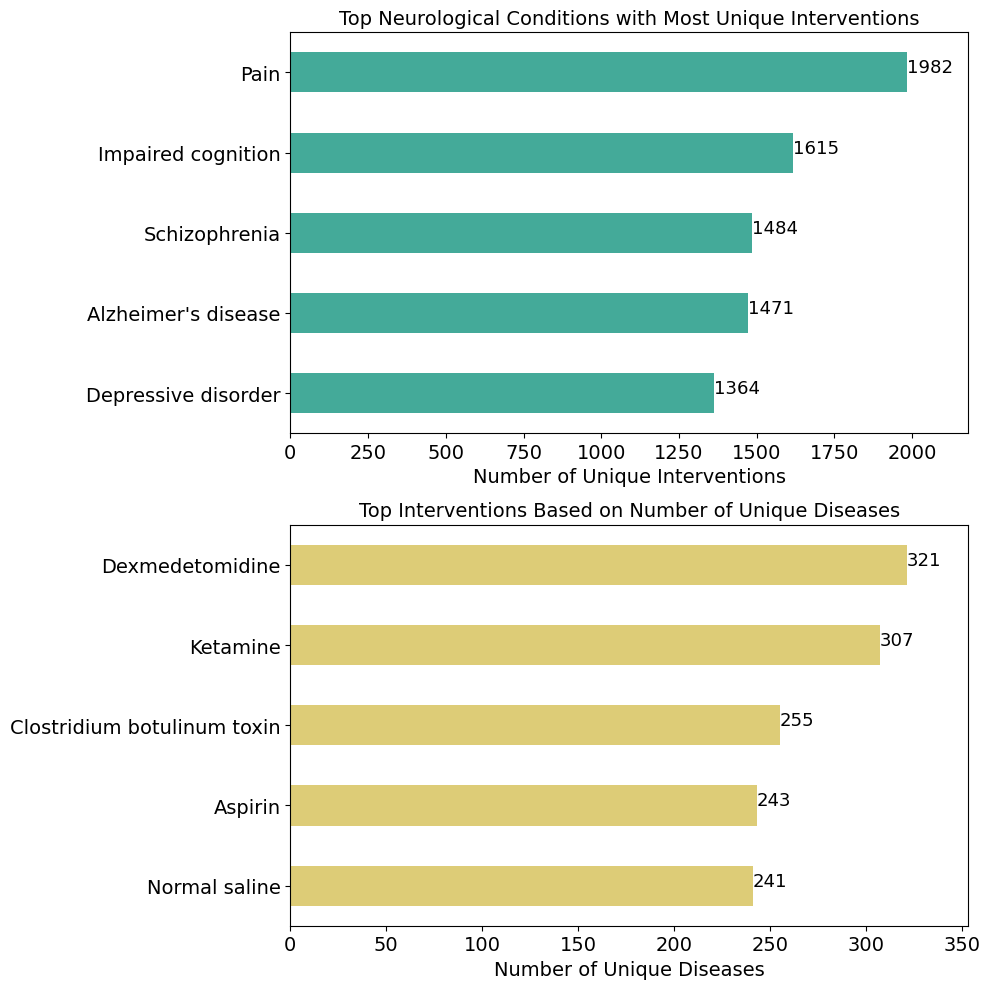

In [122]:

# First plot: Top Neurological Condition with the most unique Interventions
top_conditions = filtered_df_unique.groupby('Neurological Condition')['Drug Intervention'].nunique().sort_values(ascending=False).head()

# Second plot: Top Intervention based on the number of unique diseases it has been used for
top_interventions = filtered_df_unique.groupby('Drug Intervention')['Neurological Condition'].nunique().sort_values(ascending=False).head()

# Plotting both charts in a single figure
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Plot for top Neurological Condition with most unique Interventions
top_conditions.sort_values(ascending=True).plot(kind='barh', color='#44AA99', ax=axes[0])
axes[0].set_title('Top Neurological Conditions with Most Unique Interventions', fontsize=14)
axes[0].set_xlabel('Number of Unique Interventions', fontsize=14)
axes[0].set_ylabel('')
axes[0].tick_params(axis='y', labelsize=14)
axes[0].tick_params(axis='x', labelsize=14)

# Adding labels to the bars
for index, value in enumerate(top_conditions.sort_values(ascending=True)):
    axes[0].text(value, index, str(value),fontsize=13)

# Setting x-axis limit for the first plot
axes[0].set_xlim(0, max(top_conditions) + max(top_conditions) / 10)


# Plot for top Intervention based on the number of unique diseases
top_interventions.sort_values(ascending=True).plot(kind='barh', color='#DDCC77', ax=axes[1])
axes[1].set_title('Top Interventions Based on Number of Unique Diseases', fontsize=14)
axes[1].set_xlabel('Number of Unique Diseases', fontsize=14)
axes[1].set_ylabel('')

axes[1].tick_params(axis='y', labelsize=14)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].set_xlim(0, max(top_interventions) + max(top_interventions) / 10)

# Adding labels to the bars
for index, value in enumerate(top_interventions.sort_values(ascending=True)):
    axes[1].text(value, index, str(value), fontsize=13)
    

plt.tight_layout()

plt.savefig(f'viz/disease_intervention_frequency_{annotations_type}.pdf')

plt.show()


### interventions associated with most diseases

In [1647]:
# Step 1: Drop duplicates based on 'nct_id' and 'intervention_name'
unique_interventions_df = filtered_df[['nct_id', drug_col_name, condition_col_name]].drop_duplicates()

# Step 2: Identify the top 10 interventions
top_10_interventions = unique_interventions_df[drug_col_name].value_counts().head(10).index

print(top_10_interventions)

# Step 3: Create the dictionary for top 10 interventions with unique diseases
intervention_diseases_dict = {}
for intervention in top_10_interventions:
    # Get the unique diseases tested for each intervention
    #unique_diseases = set(unique_interventions_df[unique_interventions_df['intervention_name'] == intervention]['Neurological Disease'])
    # Get the unique diseases tested for each intervention that contain "(disorder)" in the name
    unique_diseases = {
        disease for disease in unique_interventions_df[unique_interventions_df[drug_col_name] == intervention][condition_col_name]
        if isinstance(disease, str) and "(disorder)" in disease 
    }
    intervention_diseases_dict[intervention] = unique_diseases



Index(['Risperidone (substance)', 'Anti-psychotic agent (substance)',
       'Dexmedetomidine (substance)', 'Ketamine (substance)',
       'Olanzapine (substance)', 'Levodopa (substance)',
       'Clostridium botulinum toxin (substance)', 'Quetiapine (substance)',
       'Botulinum toxin type A\n(substance)', 'Aripiprazole (substance)'],
      dtype='object', name='Drug Intervention')


In [1648]:
unique_interventions_df[drug_col_name].value_counts().head(10)

Drug Intervention
Risperidone (substance)                    901
Anti-psychotic agent (substance)           820
Dexmedetomidine (substance)                807
Ketamine (substance)                       789
Olanzapine (substance)                     676
Levodopa (substance)                       614
Clostridium botulinum toxin (substance)    583
Quetiapine (substance)                     580
Botulinum toxin type A\n(substance)        570
Aripiprazole (substance)                   555
Name: count, dtype: int64

In [1649]:
intervention_diseases_dict['Ketamine (substance)']

{'Acquired cardiac septal defect\n(disorder)',
 'Acute abdomen (disorder)',
 'Acute disease (disorder)',
 'Acute inflammatory disease (disorder)',
 'Adjustment disorder (disorder)',
 'Aneurysm (disorder)',
 'Anxiety disorder (disorder)',
 'Behavioral syndrome associated with\nphysiological disturbance and physical\nfactors (disorder)',
 'Benign intracranial hypertension (disorder)',
 'Bipolar disorder (disorder)',
 'Blood coagulation disorder (disorder)',
 'Bodily distress disorder (disorder)',
 'Bone inflammatory disease (disorder)',
 'Burn (disorder)',
 'Cancer treatment related morbidity\n(disorder)',
 'Cardiac arrest (disorder)',
 'Cardiac complication of procedure\n(disorder)',
 'Celiac disease (disorder)',
 'Central pain syndrome (disorder)',
 'Cerebrovascular accident (disorder)',
 'Childhood and adolescent fearfulness\ndisturbance (disorder)',
 'Childhood or adolescent disorder\nof social functioning (disorder)',
 'Chronic disease (disorder)',
 'Chronic mental disorder (disorde

10


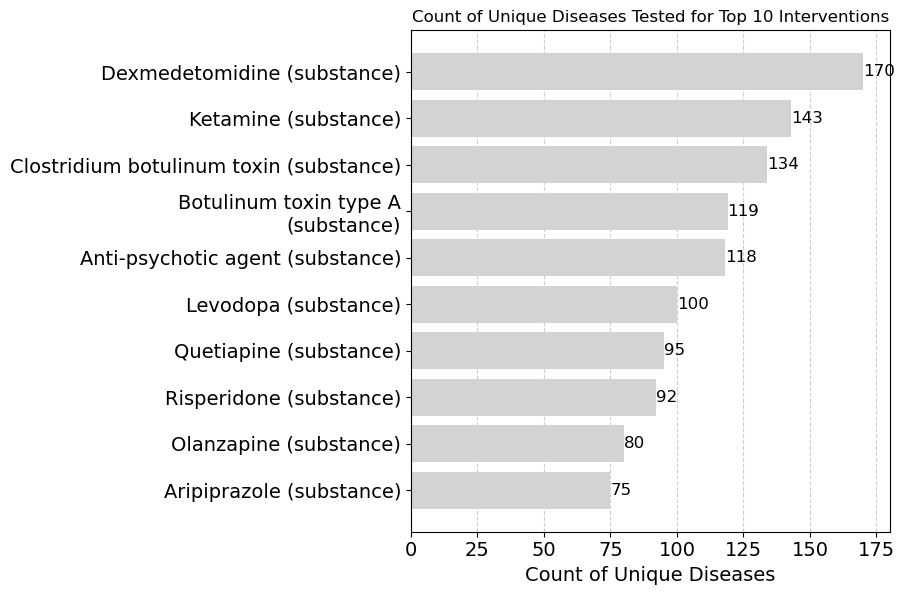

In [1650]:
# Calculate unique diseases count for each intervention
unique_diseases_counts = [len(diseases) for diseases in intervention_diseases_dict.values()]
# Extract the interventions list for ordering
interventions = list(intervention_diseases_dict.keys())
print(len(interventions))

# Sort interventions by the count of unique diseases in descending order
sorted_indices = sorted(range(len(unique_diseases_counts)), key=lambda i: unique_diseases_counts[i], reverse=False)
sorted_interventions = [interventions[i] for i in sorted_indices]
sorted_unique_diseases_counts = [unique_diseases_counts[i] for i in sorted_indices]

# Plotting with sorted data
plt.figure(figsize=(8, 6))
bars = plt.barh(sorted_interventions, sorted_unique_diseases_counts, color='lightgrey', zorder=2)

# Add labels to each bar
for bar, count in zip(bars, sorted_unique_diseases_counts):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{count}', va='center', fontsize=12)

plt.xlabel('Count of Unique Diseases', fontsize=14)
#plt.ylabel('Intervention')
plt.title('Count of Unique Diseases Tested for Top 10 Interventions')
plt.tight_layout()
plt.xlim(0, max(sorted_unique_diseases_counts) + 10)  # Adjusted to max count for relevancy
plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)
# Include grid lines on the x-axis
plt.grid(axis='x', linestyle='--', alpha=0.6, zorder=1)

plt.show()


In [1662]:
sorted_interventions[-5:]


['Anti-psychotic agent (substance)',
 'Botulinum toxin type A\n(substance)',
 'Clostridium botulinum toxin (substance)',
 'Ketamine (substance)',
 'Dexmedetomidine (substance)']

In [1651]:
interventions = list(intervention_diseases_dict.keys())
interventions

['Risperidone (substance)',
 'Anti-psychotic agent (substance)',
 'Dexmedetomidine (substance)',
 'Ketamine (substance)',
 'Olanzapine (substance)',
 'Levodopa (substance)',
 'Clostridium botulinum toxin (substance)',
 'Quetiapine (substance)',
 'Botulinum toxin type A\n(substance)',
 'Aripiprazole (substance)']

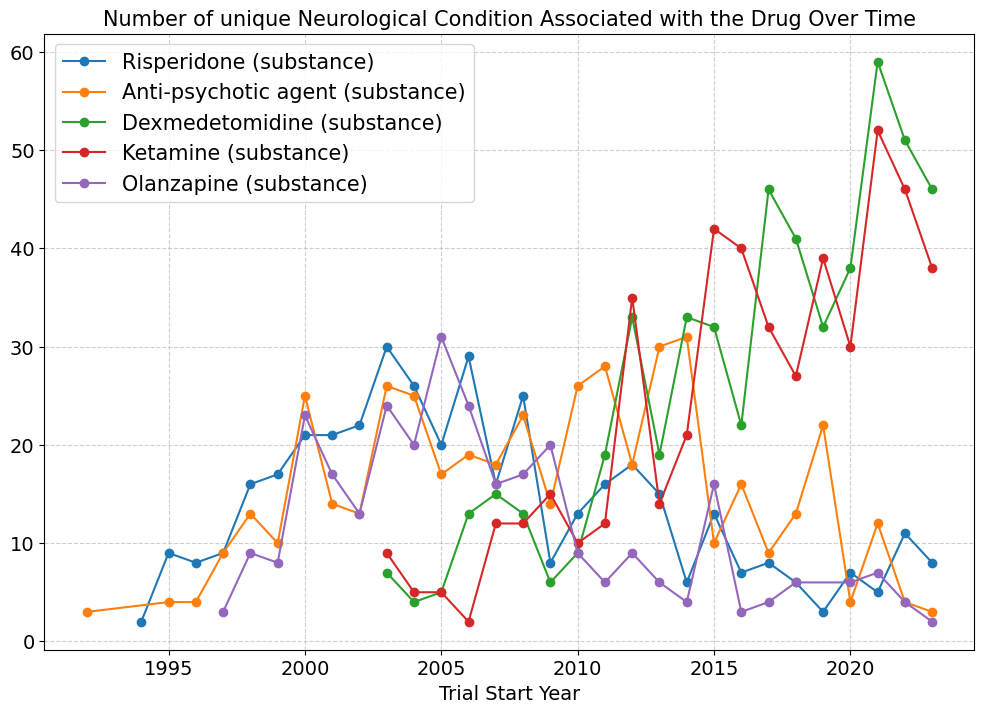

In [1664]:
# Function to get the unique diseases started in each year for given interventions
def get_unique_diseases_by_year(df, intervention):
    filtered_df = df[df[drug_col_name] == intervention]
    result = filtered_df.groupby('start_year')[condition_col_name].nunique().reset_index()
    result.columns = ['start_year', 'unique_disease_count']
    return result

# Function to plot the result
def plot_unique_diseases_over_time(df, interventions):
    plt.figure(figsize=(12, 8))
    for intervention in interventions:
        result_df = get_unique_diseases_by_year(df, intervention)
        plt.plot(result_df['start_year'], result_df['unique_disease_count'], marker='o', linestyle='-', label=intervention)
    plt.title('Number of unique Neurological Condition Associated with the Drug Over Time', fontsize=15)
    plt.xlabel('Trial Start Year', fontsize=14)
    #plt.ylabel('Unique Neurological Disease Count')
    plt.legend(fontsize=15, loc='upper left')
        # Adjusting the tick size
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
  
    plt.grid(linestyle='--', alpha=0.6, zorder=1)
    plt.savefig(f'viz/disease_per_intervention_frequency_{annotations_type}.pdf')

    plt.show()

# Example usage
selected_interventions = ['Ketamine (substance)', 'Levodopa (substance)']

plot_unique_diseases_over_time(filtered_df,interventions[:5])# sorted_interventions[-5:])
#interventions[:5])
